In [2]:
import os, importlib, sys, time

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import scipy.linalg as la
import scipy.stats as stats
import scipy.optimize as opt

In [5]:
import freqepid

# 1. load data

In [6]:
GPi = np.load('data/GPi.npz')

In [7]:
data = pd.read_feather('data/CovidCastStateAdj_2.feather').iloc[:,:-1]

In [8]:
data = data.groupby("geo_value").filter(lambda x: x.deaths.max() > 20)

In [9]:
deaths_raw = data.groupby("geo_value").apply(lambda x: sum(x.deaths))

In [10]:
data = data.groupby("geo_value", group_keys=False).apply(lambda x: 
     x[x.time_value > x[x.deaths.cumsum() > 10].time_value.min() - pd.Timedelta(30, unit='D')])

In [11]:
deaths_trunc = data.groupby("geo_value").apply(lambda x: sum(x.deaths))

In [12]:
deaths_raw - deaths_trunc

geo_value
al    0.0
az    0.0
ca    0.0
co    0.0
ct    0.0
fl    0.0
ga    0.0
il    0.0
in    0.0
la    0.0
ma    0.0
md    0.0
mi    0.0
mn    0.0
mo    0.0
ms    0.0
nc    0.0
ne    0.0
nh    0.0
nj    0.0
nv    0.0
ny    0.0
oh    0.0
pa    0.0
ri    0.0
sc    0.0
tn    0.0
tx    0.0
va    0.0
wa    0.0
dtype: float64

In [13]:
regions = np.array(data['geo_value'].unique())

In [14]:
regions, len(regions)

(array(['al', 'az', 'ca', 'co', 'ct', 'fl', 'ga', 'il', 'in', 'la', 'ma',
        'md', 'mi', 'mn', 'mo', 'ms', 'nc', 'ne', 'nh', 'nj', 'nv', 'ny',
        'oh', 'pa', 'ri', 'sc', 'tn', 'tx', 'va', 'wa'], dtype=object),
 30)

In [15]:
ivs = [5]

In [16]:
np.array(data.columns)[ivs]

array(['full_time_work_prop'], dtype=object)

In [17]:
num_region = len(regions)
d = len(ivs)+1

# 2. EDA

In [18]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.dates as mdates

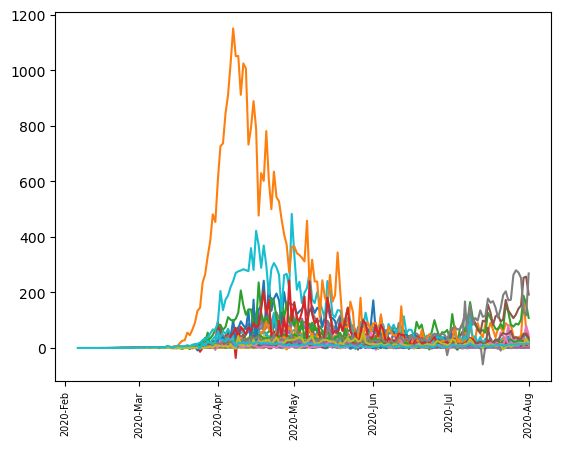

In [19]:
for r in regions:
    plt.plot(np.array(data[data.geo_value == r].time_value),
             np.array(data[data.geo_value == r].deaths), label=r)
# plt.legend()

dtFmt = mdates.DateFormatter('%Y-%b') # define the formatting
plt.gca().xaxis.set_major_formatter(dtFmt) 
# show every 12th tick on x axes
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=90, fontweight='light',  fontsize='x-small',)

plt.show()

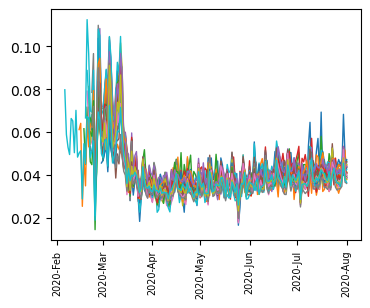

In [20]:
plt.figure(figsize=(4,3))
for i, iv in enumerate(ivs):
    # plt.subplot(2,2,i+1)
    # plt.title(np.array(data.columns)[iv]); # plt.xlabel('days')
    for r in regions:
        plt.plot(np.array(data[data.geo_value == r].time_value),
                 np.array(data[data.geo_value == r].iloc[:,iv]),
                 linewidth=1)

dtFmt = mdates.DateFormatter('%Y-%b') # define the formatting
plt.gca().xaxis.set_major_formatter(dtFmt) 
# show every 12th tick on x axes
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=90, fontweight='light',  fontsize='x-small',)        

plt.show()

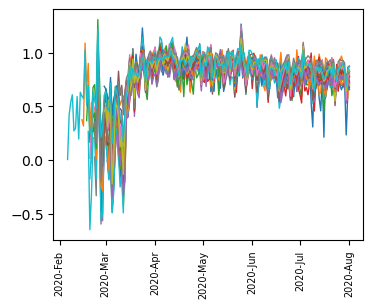

In [21]:
plt.figure(figsize=(4,3))
for i, iv in enumerate(ivs):
    # plt.subplot(2,2,i+1)
    # plt.title(np.array(data.columns)[iv]); # plt.xlabel('days')
    for r in regions:
        plt.plot(np.array(data[data.geo_value == r].time_value),
                 np.array(data[data.geo_value == r].iloc[:,iv]) * (-20) + 1.6,
                 linewidth=1)

dtFmt = mdates.DateFormatter('%Y-%b') # define the formatting
plt.gca().xaxis.set_major_formatter(dtFmt) 
# show every 12th tick on x axes
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=90, fontweight='light',  fontsize='x-small',)        

plt.show()

# 3. fit

In [22]:
model = freqepid.Model(GPi['g'], GPi['pi'], T0=40, family='nbinom')

In [436]:
ns_mle = np.zeros(num_region)
ms_mle = np.zeros(num_region)
bs_mle = np.zeros((num_region,d))
covs_mle = np.zeros((num_region,d+2,d+2))

In [437]:
for i_region, r \
in enumerate(regions):
    start_region = time.time()
    sys.__stdout__.write("Program at %s started \n"%r)
    sys.__stdout__.flush()  
    
    # data
    Y = np.array(data[data.geo_value == r].deaths)
    T = Y.shape[0]
    
    A = np.zeros([T, d])
    A[:,0] = np.full(T, 1)
    A[:,1:] = np.array(data[data.geo_value == r].iloc[:,ivs])*(-20) + 1.6
    
    
    # fit
    nmle, mmle, bmle, ll =\
    model.fit(A, Y, n_iter=1000, step_size=1,
              history=False, verbose=False)
    
    ns_mle[i_region] = nmle
    ms_mle[i_region] = mmle
    bs_mle[i_region,:] = bmle
    
    Ihat_dth, Ihat_hac, Ihat_sdw =\
    model.inference(A, Y, nmle, mmle, bmle)
    
    covs_mle[i_region] = la.pinv(Ihat_sdw)

    sys.__stdout__.write("Inference at %s finished, lapse: %f sec. \n"
                     %(r, time.time() - start_region))
    sys.__stdout__.flush() 

Program at al started 


/Users/blueconet/mambaforge/envs/freqepid/lib/python3.10/site-packages/freqepid/model.py:141: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  bhaty = np.linalg.lstsq(Xy, Yy)[0]
/Users/blueconet/mambaforge/envs/freqepid/lib/python3.10/site-packages/freqepid/model.py:146: RuntimeWarning: divide by zero encountered in log
  log_err_ratio = np.log(Y / self.predict_EY(A, 0, binit))
/Users/blueconet/mambaforge/envs/freqepid/lib/python3.10/site-packages/freqepid/model.py:146: RuntimeWarning: invalid value encountered in log
  log_err_ratio = np.log(Y / self.predict_EY(A, 0, binit))


Inference at al finished, lapse: 17.776462 sec. 
Program at az started 
Inference at az finished, lapse: 17.544778 sec. 
Program at ca started 
Inference at ca finished, lapse: 19.703983 sec. 
Program at co started 
Inference at co finished, lapse: 18.711988 sec. 
Program at ct started 
Inference at ct finished, lapse: 21.251328 sec. 
Program at fl started 
Inference at fl finished, lapse: 18.629523 sec. 
Program at ga started 
Inference at ga finished, lapse: 19.718233 sec. 
Program at il started 
Inference at il finished, lapse: 21.148755 sec. 
Program at in started 
Inference at in finished, lapse: 16.636938 sec. 
Program at la started 
Inference at la finished, lapse: 18.319326 sec. 
Program at ma started 
Inference at ma finished, lapse: 23.253075 sec. 
Program at md started 
Inference at md finished, lapse: 18.740461 sec. 
Program at mi started 
Inference at mi finished, lapse: 22.277956 sec. 
Program at mn started 
Inference at mn finished, lapse: 17.323346 sec. 
Program at mo s

In [438]:
# np.savez('result_freqepid_delphi.npz',
#          ns_mle = ns_mle, ms_mle = ms_mle, 
#          bs_mle = bs_mle, covs_mle = covs_mle)

## plots

In [23]:
locals().update(np.load('result_freqepid_delphi.npz'))

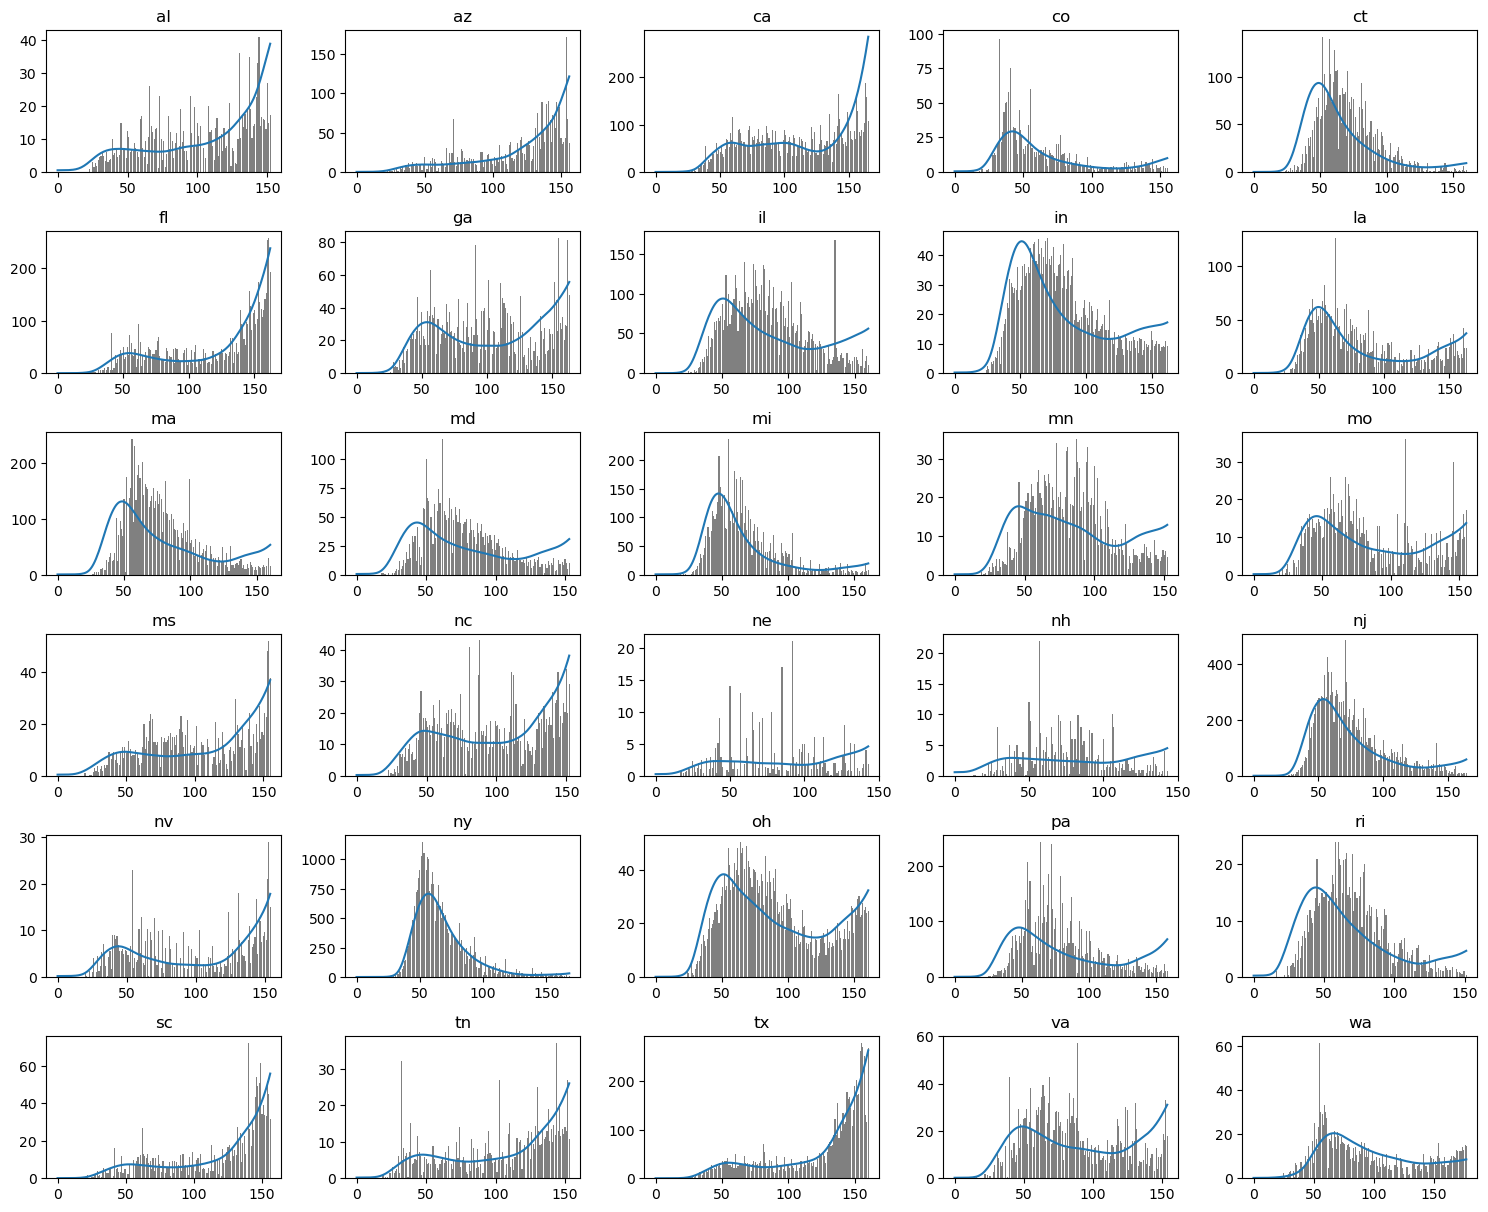

In [29]:
plt.figure(figsize=(15, int(len(regions)/5+1)*2))

for i, r in enumerate(regions):
    plt.subplot(int(len(regions)/5+1),5,i+1)
    
    Y = np.array(data[data.geo_value == r].deaths)
    T = Y.shape[0]
    
    A = np.zeros([T, d])
    A[:,0] = np.full(T, 1)
    A[:,1:] = np.array(data[data.geo_value == r].iloc[:,ivs]) * (-20) + 1.6

    plt.bar(np.arange(T), Y, color='grey')
    plt.plot(model.predict_EY(A, ms_mle[i], bs_mle[i]))
    plt.title('%s'%r)
    plt.ylim(bottom=0)
    
plt.tight_layout()

In [33]:
Vs_mle = covs_mle

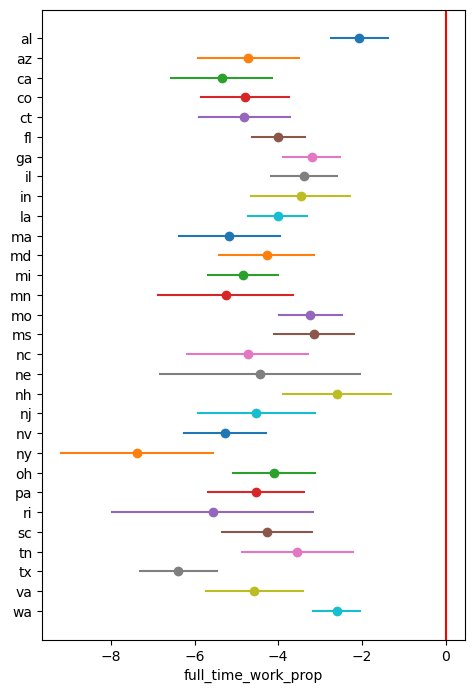

In [34]:
plt.figure(figsize=(12,18))
for k, iv in enumerate(ivs):
    plt.subplot(2,2,k+1)
    plt.gca().invert_yaxis()
    for i, r in enumerate(regions):
        se2 = np.diag(Vs_mle[i])[k+3]
        if se2 > 0:
            plt.plot([bs_mle[i,k+1]-2*np.sqrt(se2), 
                      bs_mle[i,k+1]+2*np.sqrt(se2)],
                     [i, i], color='C%d'%i)
        else:
            plt.axhline(y=i, color='C%d'%i)
        plt.scatter(bs_mle[i,k+1], i, color='C%d'%i)

    plt.axvline(x=0, color='red')
    plt.yticks(np.arange(len(regions)), regions) 
    plt.xlabel(np.array(data.columns)[iv])
plt.show()

(-10.0, 0.0)

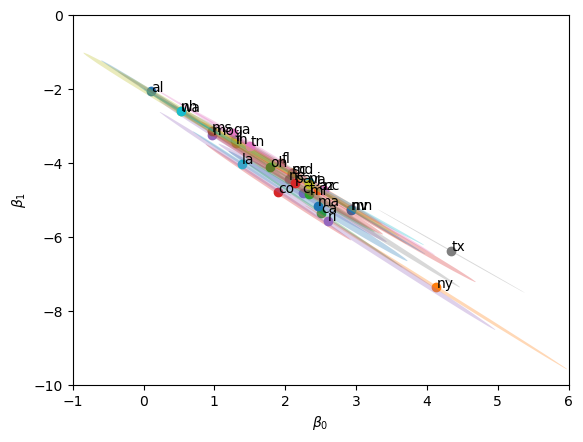

In [35]:
for i_region, (r, bmle, Vmle) \
in enumerate(zip(regions, bs_mle, Vs_mle)):
    p = plt.scatter(*bmle, label="%d"%i_region)
    plt.annotate(r, bmle)
    freqepid.confidence_ellipse(
        bmle, Vmle[2:,2:], n_std=np.sqrt(stats.chi2(2).ppf(0.95)),
        facecolor=p.get_facecolor(), alpha=0.3)
plt.xlabel(r"$\beta_0$"); plt.ylabel(r"$\beta_1$"); # plt.legend()
plt.xlim(-1, 6); plt.ylim(-10, 0)

# 3. EBCR

In [36]:
ths_mle = np.concatenate([ms_mle[:,None], bs_mle], -1)
Vs_mle = Vs_mle[:,1:,1:]

In [37]:
result_ebcr = freqepid.EBCR(ths_mle, Vs_mle, num_mc=1000)

In [38]:
result_ebcr.th_o

array([ 2.72247855,  2.12199699, -4.39140191])

In [39]:
result_ebcr.Phi2

array([[ 0.52932335, -0.52203258,  0.45693495],
       [-0.52203258,  1.1686858 , -1.19897176],
       [ 0.45693495, -1.19897176,  1.31295338]])

In [40]:
ths_eb = result_ebcr.ths_eb

In [41]:
Vs_eb = result_ebcr.covs_eb

In [42]:
chi_pa = result_ebcr.chi_pa(0.05)

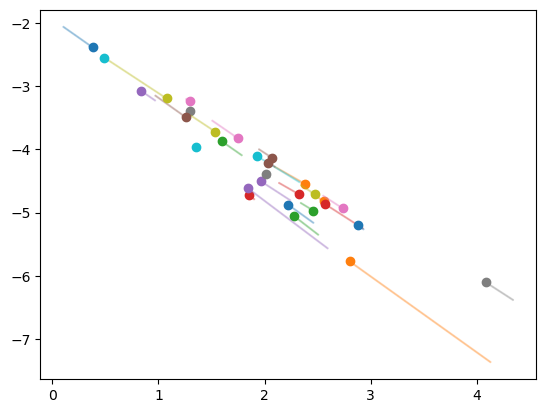

In [43]:
for i in np.arange(num_region):
    p = plt.scatter(*ths_eb[i,1:])
    plt.arrow(*ths_mle[i,1:], *(ths_eb[i,1:]-ths_mle[i,1:]), width=0.01, 
             length_includes_head=True,
             color=p.get_facecolor(), alpha=0.3)

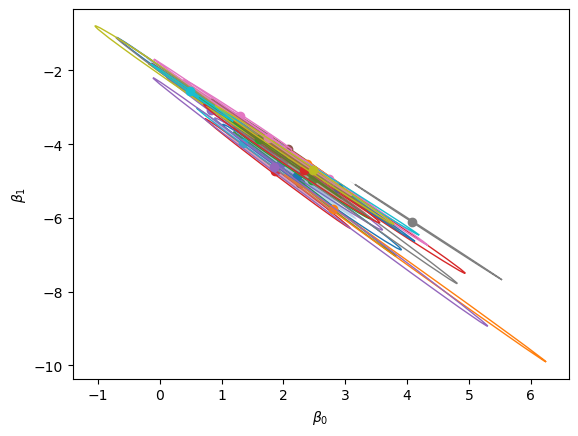

In [44]:
for i in np.arange(num_region):
    p = plt.scatter(ths_eb[i,1], ths_eb[i,2])
    freqepid.confidence_ellipse(
        ths_eb[i,1:], Vs_eb[i,1:,1:], n_std = chi_pa,
        facecolor=p.get_facecolor(), alpha=0.3)
    freqepid.confidence_ellipse(
        ths_mle[i,1:], Vs_mle[i,1:,1:], n_std = chi_pa,
        edgecolor=p.get_facecolor(), facecolor='none', alpha=1)
plt.xlabel(r"$\beta_0$"); plt.ylabel(r"$\beta_1$"); #plt.legend(loc=(1.02,0))

## robust CR

In [45]:
rho_pa = np.zeros(num_region)
rho_l = np.zeros(num_region)

In [46]:
for i in np.arange(num_region):
    start_iter = time.time()
    
    rho_pa[i] = result_ebcr.cv.rho(chi_pa, result_ebcr.m2s[i],
                                   result_ebcr.m4s[i]+1e-2)['alpha']
    
    rho_l[i] = result_ebcr.cv.rho_l(chi_pa, result_ebcr.m2s[i],
                                    result_ebcr.m4s[i])['alpha']
    
    print("region %d finished, lapse: %.2f sec."
          %(i, time.time()-start_iter))

region 0 finished, lapse: 0.39 sec.
region 1 finished, lapse: 0.29 sec.
region 2 finished, lapse: 0.43 sec.
region 3 finished, lapse: 0.28 sec.
region 4 finished, lapse: 0.28 sec.
region 5 finished, lapse: 0.28 sec.
region 6 finished, lapse: 0.28 sec.
region 7 finished, lapse: 0.28 sec.
region 8 finished, lapse: 0.45 sec.
region 9 finished, lapse: 0.29 sec.
region 10 finished, lapse: 0.28 sec.
region 11 finished, lapse: 0.27 sec.
region 12 finished, lapse: 0.29 sec.
region 13 finished, lapse: 0.28 sec.
region 14 finished, lapse: 0.28 sec.
region 15 finished, lapse: 0.28 sec.
region 16 finished, lapse: 0.28 sec.
region 17 finished, lapse: 0.40 sec.
region 18 finished, lapse: 0.30 sec.
region 19 finished, lapse: 0.30 sec.
region 20 finished, lapse: 0.28 sec.
region 21 finished, lapse: 0.43 sec.
region 22 finished, lapse: 0.28 sec.
region 23 finished, lapse: 0.28 sec.
region 24 finished, lapse: 0.44 sec.
region 25 finished, lapse: 0.28 sec.
region 26 finished, lapse: 0.28 sec.
region 27 f

In [47]:
rho_pa

array([0.07897128, 0.08274615, 0.12535189, 0.09428088, 0.10448051,
       0.06924934, 0.08637189, 0.10237254, 0.16693622, 0.08702576,
       0.11087474, 0.09405058, 0.08501334, 0.1032479 , 0.08002327,
       0.08696017, 0.09578821, 0.16127165, 0.09859662, 0.10652886,
       0.06709051, 0.11817284, 0.08036409, 0.10506524, 0.19495247,
       0.0745095 , 0.08452079, 0.06073964, 0.08908523, 0.09226495])

In [48]:
rho_l

array([0.0787062 , 0.08204269, 0.12531288, 0.093068  , 0.10342801,
       0.06911249, 0.08601383, 0.10166237, 0.16689487, 0.08651688,
       0.10933013, 0.09347757, 0.0846399 , 0.10172706, 0.0796933 ,
       0.08633584, 0.09433252, 0.16125657, 0.09770739, 0.10441184,
       0.06692923, 0.11814451, 0.0798446 , 0.10408939, 0.19549703,
       0.07414555, 0.08378176, 0.0606348 , 0.08842605, 0.09178489])

In [49]:
chi_eb = np.zeros(num_region)

In [50]:
for i in np.arange(num_region):
    start_iter = time.time()
    
    chi_eb[i] = result_ebcr.chi_eb(i, 0.05, linear=True)
    
    print("region %d finished, lapse: %.2f sec."
          %(i, time.time()-start_iter))

region 0 finished, lapse: 3.16 sec.
region 1 finished, lapse: 2.97 sec.
region 2 finished, lapse: 2.76 sec.
region 3 finished, lapse: 2.77 sec.
region 4 finished, lapse: 2.95 sec.
region 5 finished, lapse: 3.20 sec.
region 6 finished, lapse: 2.74 sec.
region 7 finished, lapse: 3.18 sec.
region 8 finished, lapse: 2.58 sec.
region 9 finished, lapse: 2.94 sec.
region 10 finished, lapse: 2.95 sec.
region 11 finished, lapse: 2.94 sec.
region 12 finished, lapse: 2.79 sec.
region 13 finished, lapse: 2.98 sec.
region 14 finished, lapse: 3.19 sec.
region 15 finished, lapse: 2.98 sec.
region 16 finished, lapse: 2.76 sec.
region 17 finished, lapse: 2.99 sec.
region 18 finished, lapse: 3.25 sec.
region 19 finished, lapse: 2.99 sec.
region 20 finished, lapse: 3.18 sec.
region 21 finished, lapse: 3.00 sec.
region 22 finished, lapse: 3.16 sec.
region 23 finished, lapse: 2.94 sec.
region 24 finished, lapse: 2.82 sec.
region 25 finished, lapse: 2.97 sec.
region 26 finished, lapse: 2.97 sec.
region 27 f

In [51]:
chi_eb

array([2.99664725, 3.02174654, 3.28650901, 3.09189597, 3.14269993,
       2.93826971, 3.04044594, 3.12861294, 3.44925603, 3.04594194,
       3.17618266, 3.0853584 , 3.03273373, 3.14048653, 3.0031895 ,
       3.04657268, 3.10171937, 3.52613584, 3.11235905, 3.15955601,
       2.92248659, 3.27351973, 3.0065154 , 3.1447605 , 3.80715376,
       2.97198858, 3.03269746, 2.87483434, 3.05940265, 3.0750465 ])

In [52]:
rho_eb = np.zeros(num_region)

In [53]:
for i in np.arange(num_region):
    start_iter = time.time()
    
#     rho_eb[i] = result_ebcr.cv.rho(chi_pa, result_ebcr.m2s[i],
#                                    result_ebcr.m4s[i]+1e-2)['alpha']
    
    rho_eb[i] = result_ebcr.cv.rho_l(chi_eb[i], result_ebcr.m2s[i],
                                    result_ebcr.m4s[i])['alpha']
    
    print("region %d finished, lapse: %.2f sec."
          %(i, time.time()-start_iter))

region 0 finished, lapse: 0.23 sec.
region 1 finished, lapse: 0.22 sec.
region 2 finished, lapse: 0.22 sec.
region 3 finished, lapse: 0.22 sec.
region 4 finished, lapse: 0.22 sec.
region 5 finished, lapse: 0.22 sec.
region 6 finished, lapse: 0.22 sec.
region 7 finished, lapse: 0.22 sec.
region 8 finished, lapse: 0.22 sec.
region 9 finished, lapse: 0.22 sec.
region 10 finished, lapse: 0.22 sec.
region 11 finished, lapse: 0.22 sec.
region 12 finished, lapse: 0.22 sec.
region 13 finished, lapse: 0.22 sec.
region 14 finished, lapse: 0.22 sec.
region 15 finished, lapse: 0.22 sec.
region 16 finished, lapse: 0.22 sec.
region 17 finished, lapse: 0.22 sec.
region 18 finished, lapse: 0.22 sec.
region 19 finished, lapse: 0.22 sec.
region 20 finished, lapse: 0.22 sec.
region 21 finished, lapse: 0.22 sec.
region 22 finished, lapse: 0.22 sec.
region 23 finished, lapse: 0.22 sec.
region 24 finished, lapse: 0.23 sec.
region 25 finished, lapse: 0.22 sec.
region 26 finished, lapse: 0.22 sec.
region 27 f

In [54]:
rho_eb

array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])

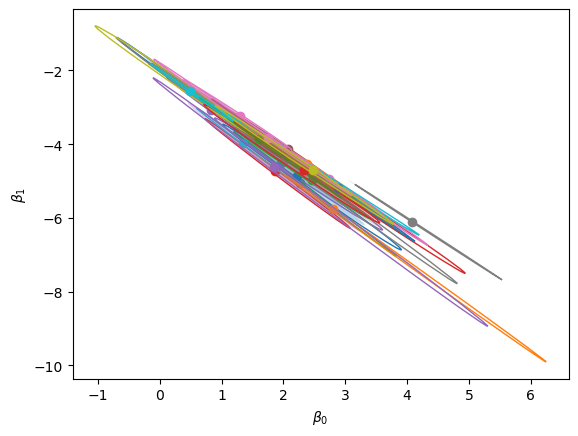

In [57]:
for i in np.arange(num_region):
    p = plt.scatter(ths_eb[i,1], ths_eb[i,2])
    freqepid.confidence_ellipse(
        ths_eb[i,1:], Vs_eb[i,1:,1:], n_std = chi_eb[i],
        facecolor=p.get_facecolor(), alpha=0.3)
    freqepid.confidence_ellipse(
        ths_mle[i,1:], Vs_mle[i,1:,1:], n_std = chi_pa,
        edgecolor=p.get_facecolor(), facecolor='none', alpha=1)
plt.xlabel(r"$\beta_0$"); plt.ylabel(r"$\beta_1$"); #plt.legend(loc=(1.02,0))

In [58]:
# plt.figure(figsize=(12,9))

# plt.subplot(1,2,1)
# plt.gca().invert_yaxis()
# for i, r in enumerate(regions):
#     se2 = np.diag(Vs_mle[i])[k+3]
#     if se2 > 0:
#         plt.plot([bs_mle[i,k+1]-chi_pa*np.sqrt(se2), 
#                   bs_mle[i,k+1]+chi_pa*np.sqrt(se2)],
#                  [i, i], color='C%d'%i)
#     else:
#         plt.axhline(y=i, color='C%d'%i)
#     plt.scatter(bs_mle[i,k+1], i, color='C%d'%i)

# plt.axvline(x=0, color='red')
# plt.yticks(np.arange(len(regions)), regions)
# plt.xlim(-20,20)

# plt.subplot(1,2,2)
# plt.gca().invert_yaxis()
# for i, r in enumerate(regions):
#     se2 = np.diag(covs_eb[i])[k+2]
#     if se2 > 0:
#         plt.plot([ths_eb[i,k+2]-chi_eb[i]*np.sqrt(se2), 
#                   ths_eb[i,k+2]+chi_eb[i]*np.sqrt(se2)],
#                  [i, i], color='C%d'%i)
#     else:
#         plt.axhline(y=i, color='C%d'%i)
#     plt.scatter(ths_eb[i,k+2], i, color='C%d'%i)

# plt.axvline(x=0, color='red')
# plt.yticks(np.arange(len(regions)), regions)
# plt.xlim(-20,20)

# plt.show()

In [59]:
# argsort_Y = np.argsort([np.max(Y) for Y in Ys_raw])

In [60]:
# argsort_T = np.argsort([Y.shape[0] for Y in Ys_raw])

In [61]:
argsort_se = np.argsort([np.diag(Vs_mle[i])[2] for i in np.arange(num_region)])[::-1]

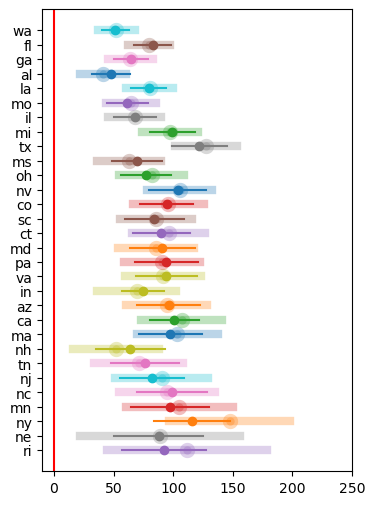

In [62]:
plt.figure(figsize=(4,6))

for j, i in enumerate(argsort_se):
    se2 = np.diag(Vs_mle[i])[2]
    if se2 > 0:
        plt.plot(np.array([ths_mle[i,2]-chi_pa*np.sqrt(se2), 
                  ths_mle[i,2]+chi_pa*np.sqrt(se2)])*(-20),
                 [j, j], color='C%d'%i, alpha=0.3, linewidth=6)
    else:
        plt.axhline(y=j, color='C%d'%i, alpha=0.3, linewidth=6)
    plt.scatter(ths_mle[i,2]*(-20), j, color='C%d'%i, alpha=0.3, linewidth=5)

    se2 = np.diag(Vs_eb[i])[2]
    if se2 > 0:
        plt.plot(np.array([ths_eb[i,2]-chi_eb[i]*np.sqrt(se2), 
                  ths_eb[i,2]+chi_eb[i]*np.sqrt(se2)])*(-20),
                 [j, j], color='C%d'%i)
    else:
        plt.axhline(y=j, color='C%d'%i)
    plt.scatter(ths_eb[i,2]*(-20), j, color='C%d'%i)

plt.axvline(x=0, color='red')
plt.yticks(np.arange(len(regions)), regions[argsort_se])
plt.xlim(-10,250)

plt.show()

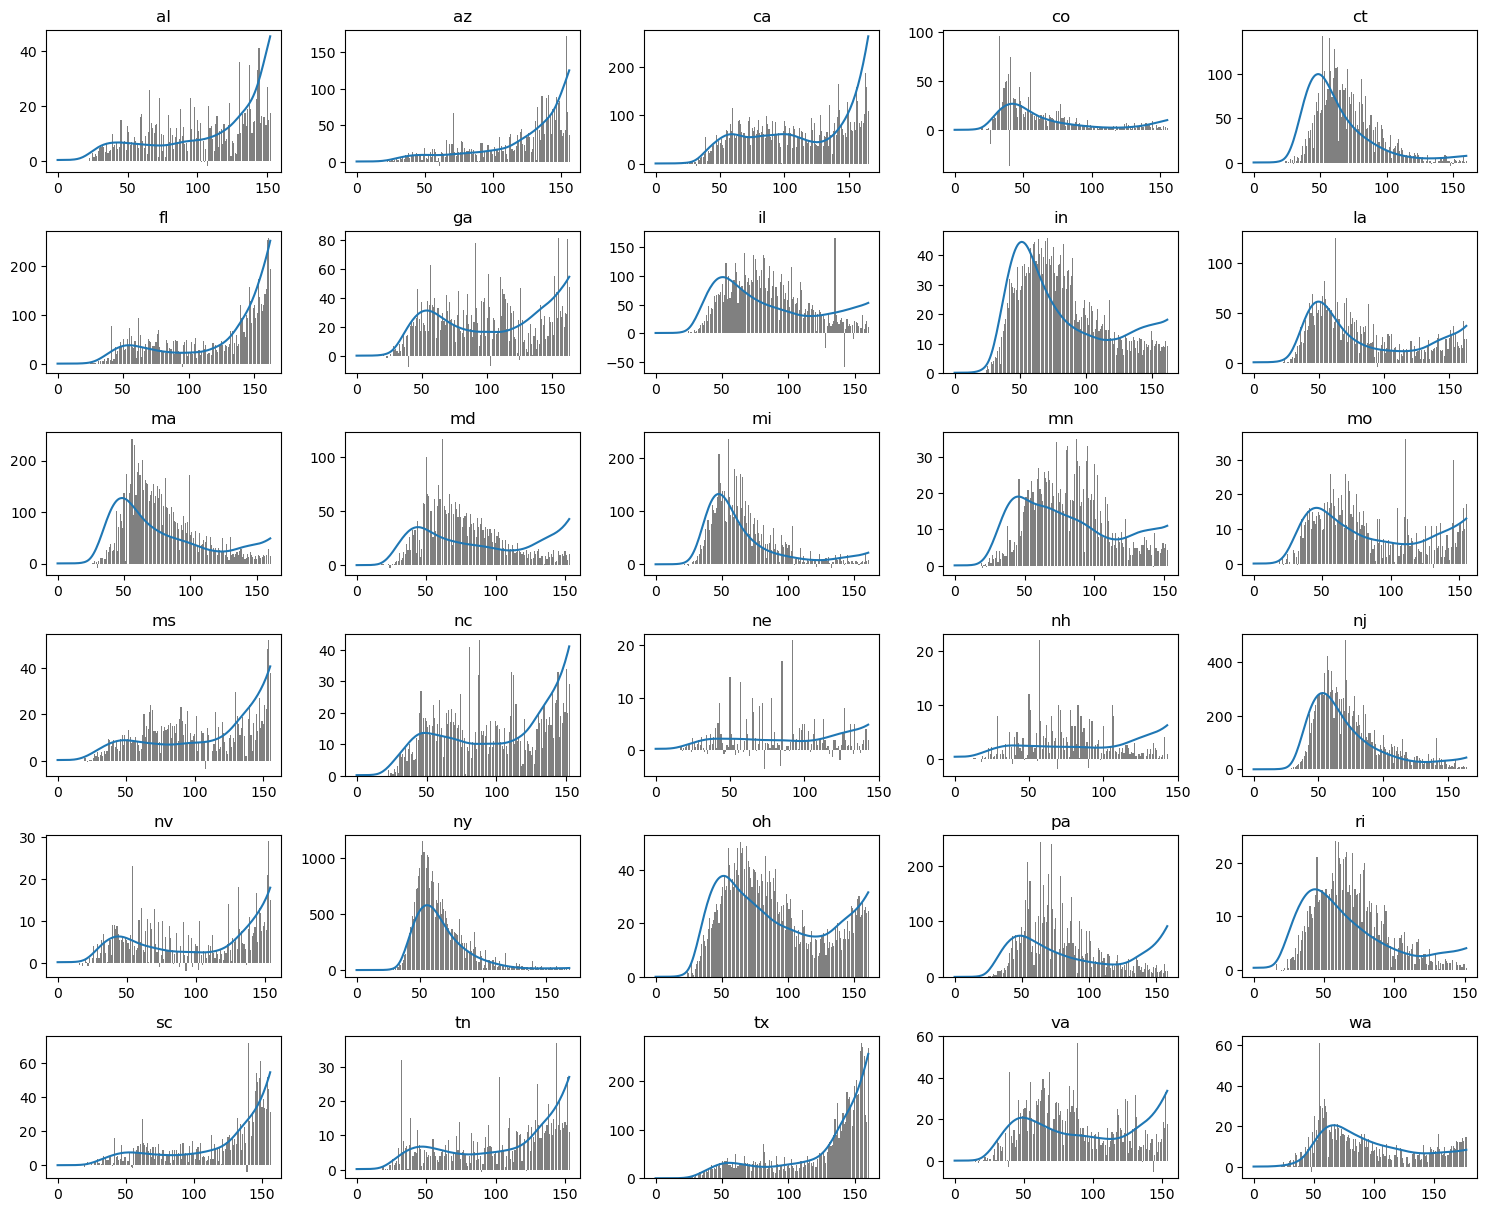

In [63]:
plt.figure(figsize=(15, int(len(regions)/5+1)*2))

for i, r in enumerate(regions):
    plt.subplot(int(len(regions)/5+1),5,i+1)
    
    Y = np.array(data[data.geo_value == r].deaths)
    T = Y.shape[0]
    
    A = np.zeros([T, d])
    A[:,0] = np.full(T, 1)
    A[:,1:] = np.array(data[data.geo_value == r].iloc[:,ivs]) * (-20) + 1.6

    plt.bar(np.arange(T), Y, color='grey')
    plt.plot(model.predict_EY(A, ths_eb[i,0], ths_eb[i,1:]))
    plt.title('%s'%r)
    
plt.tight_layout()

## epidemia result

In [81]:
result_nonshrink = pd.read_feather('result_epidemia_delphi_nonshrink.feather')

In [82]:
ths_ns = np.array(result_nonshrink.iloc[:,:3])
Vs_ns = np.array(result_nonshrink.iloc[:,3:]).reshape([-1,3,3])

In [83]:
result_epidemia = pd.read_feather('result_epidemia_delphi.feather')

In [84]:
ths_smp = np.stack([
    np.stack([
        np.log(result_epidemia['seeds[%s]'%r]),
#         result_epidemia['R|(Intercept)'] 
#            + 
        result_epidemia['R|b[(Intercept) region:%s]'%r],
        result_epidemia['R|intervention'] 
           + result_epidemia['R|b[intervention region:%s]'%r]
    ], 0)
    for r in regions
], 0)

In [85]:
ths_epi = np.mean(ths_smp, -1)
Vs_epi = np.stack([
    np.cov(th_smp) for th_smp in ths_smp
])

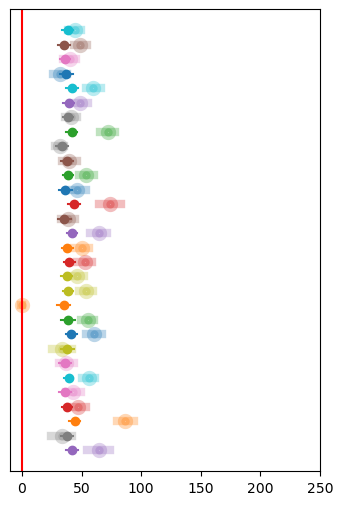

In [86]:
plt.figure(figsize=(4,6))

for j, i in enumerate(argsort_se):
    se2 = np.diag(Vs_ns[i])[2]
    if se2 > 0:
        plt.plot(np.array([ths_ns[i,2]-chi_pa*np.sqrt(se2), 
                  ths_ns[i,2]+chi_pa*np.sqrt(se2)])*(-20),
                 [j, j], color='C%d'%i, alpha=0.3, linewidth=6)
    else:
        plt.axhline(y=j, color='C%d'%i, alpha=0.3, linewidth=6)
    plt.scatter(ths_ns[i,2]*(-20), j, color='C%d'%i, alpha=0.3, linewidth=5)
    
    se2 = np.diag(Vs_epi[i])[2]
    if se2 > 0:
        plt.plot(np.array([ths_epi[i,2]-2*np.sqrt(se2), 
                  ths_epi[i,2]+2*np.sqrt(se2)])*(-20),
                 [j, j], color='C%d'%i)
    else:
        plt.axhline(y=i, color='C%d'%i)
    plt.scatter(ths_epi[i,2]*(-20), j, color='C%d'%i)

plt.axvline(x=0, color='red')
plt.yticks([],[])
plt.xlim(-10,250)

plt.show()

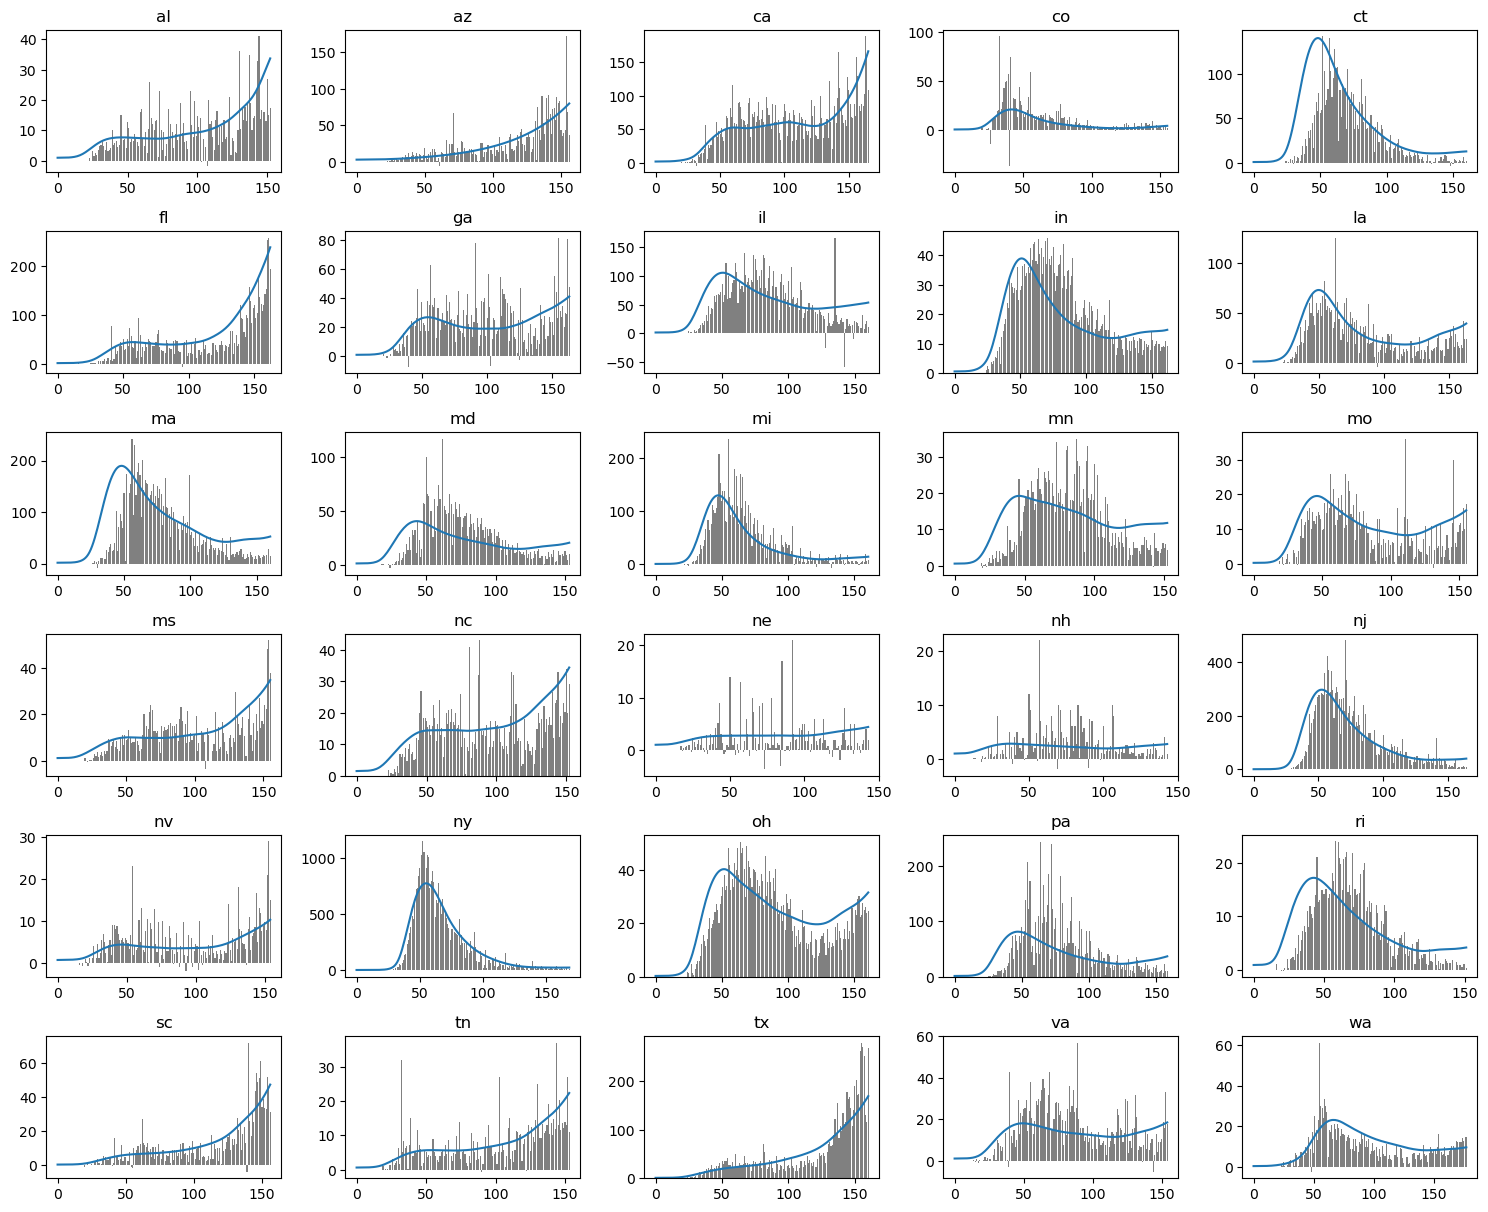

In [87]:
plt.figure(figsize=(15, int(len(regions)/5+1)*2))

for i, r in enumerate(regions):
    plt.subplot(int(len(regions)/5+1),5,i+1)
    
    Y = np.array(data[data.geo_value == r].deaths)
    T = Y.shape[0]
    
    A = np.zeros([T, d])
    A[:,0] = np.full(T, 1)
    A[:,1:] = np.array(data[data.geo_value == r].iloc[:,ivs]) * (-20) + 1.6

    plt.bar(np.arange(T), Y, color='grey')
    plt.plot(model.predict_EY(A, ths_ns[i,0], ths_ns[i,1:]))
    plt.title('%s'%r)
    
plt.tight_layout()

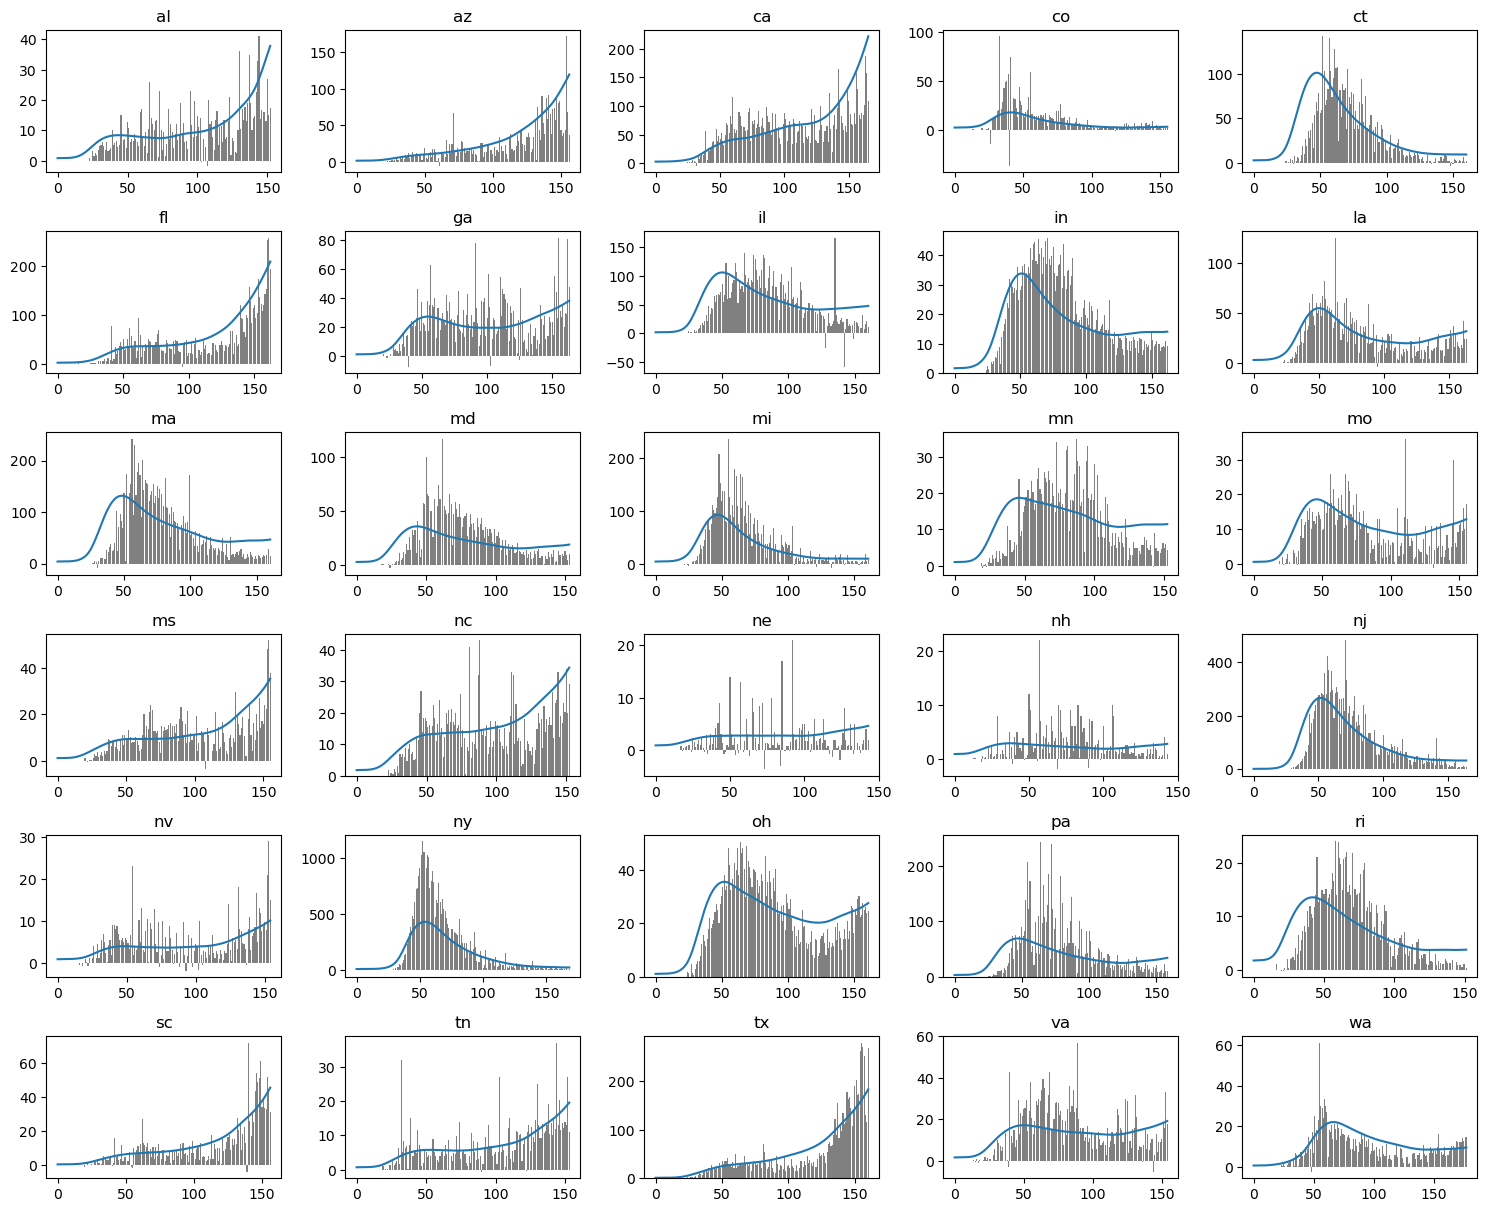

In [88]:
plt.figure(figsize=(15, int(len(regions)/5+1)*2))

for i, r in enumerate(regions):
    plt.subplot(int(len(regions)/5+1),5,i+1)
    
    Y = np.array(data[data.geo_value == r].deaths)
    T = Y.shape[0]
    
    A = np.zeros([T, d])
    A[:,0] = np.full(T, 1)
    A[:,1:] = np.array(data[data.geo_value == r].iloc[:,ivs]) * (-20) + 1.6

    plt.bar(np.arange(T), Y, color='grey')
    plt.plot(model.predict_EY(A, ths_epi[i,0], ths_epi[i,1:]))
    plt.title('%s'%r)
    
plt.tight_layout()

## epidemia result

In [72]:
result_nonshrink = pd.read_feather('result_epidemia_delphi_nonshrink_normal_4.feather')

In [73]:
ths_ns = np.array(result_nonshrink.iloc[:,:3])
Vs_ns = np.array(result_nonshrink.iloc[:,3:]).reshape([-1,3,3])

In [74]:
result_epidemia = pd.read_feather('result_epidemia_delphi_normal_4.feather')

In [75]:
ths_smp = np.stack([
    np.stack([
        np.log(result_epidemia['seeds[%s]'%r]),
        result_epidemia['R|(Intercept)'] 
           + 
        result_epidemia['R|b[(Intercept) region:%s]'%r],
        result_epidemia['R|intervention'] 
           + result_epidemia['R|b[intervention region:%s]'%r]
    ], 0)
    for r in regions
], 0)

In [76]:
ths_epi = np.mean(ths_smp, -1)
Vs_epi = np.stack([
    np.cov(th_smp) for th_smp in ths_smp
])

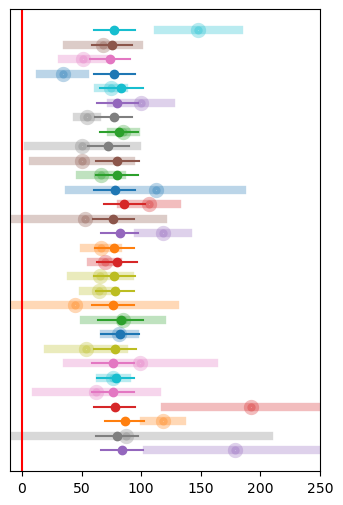

In [79]:
plt.figure(figsize=(4,6))

for j, i in enumerate(argsort_se):
    se2 = np.diag(Vs_ns[i])[2]
    if se2 > 0:
        plt.plot(np.array([ths_ns[i,2]-chi_pa*np.sqrt(se2), 
                  ths_ns[i,2]+chi_pa*np.sqrt(se2)])*(-20),
                 [j, j], color='C%d'%i, alpha=0.3, linewidth=6)
    else:
        plt.axhline(y=j, color='C%d'%i, alpha=0.3, linewidth=6)
    plt.scatter(ths_ns[i,2]*(-20), j, color='C%d'%i, alpha=0.3, linewidth=5)
    
    se2 = np.diag(Vs_epi[i])[2]
    if se2 > 0:
        plt.plot(np.array([ths_epi[i,2]-2*np.sqrt(se2), 
                  ths_epi[i,2]+2*np.sqrt(se2)])*(-20),
                 [j, j], color='C%d'%i)
    else:
        plt.axhline(y=i, color='C%d'%i)
    plt.scatter(ths_epi[i,2]*(-20), j, color='C%d'%i)

plt.axvline(x=0, color='red')
plt.yticks([],[])
plt.xlim(-10,250)

plt.show()

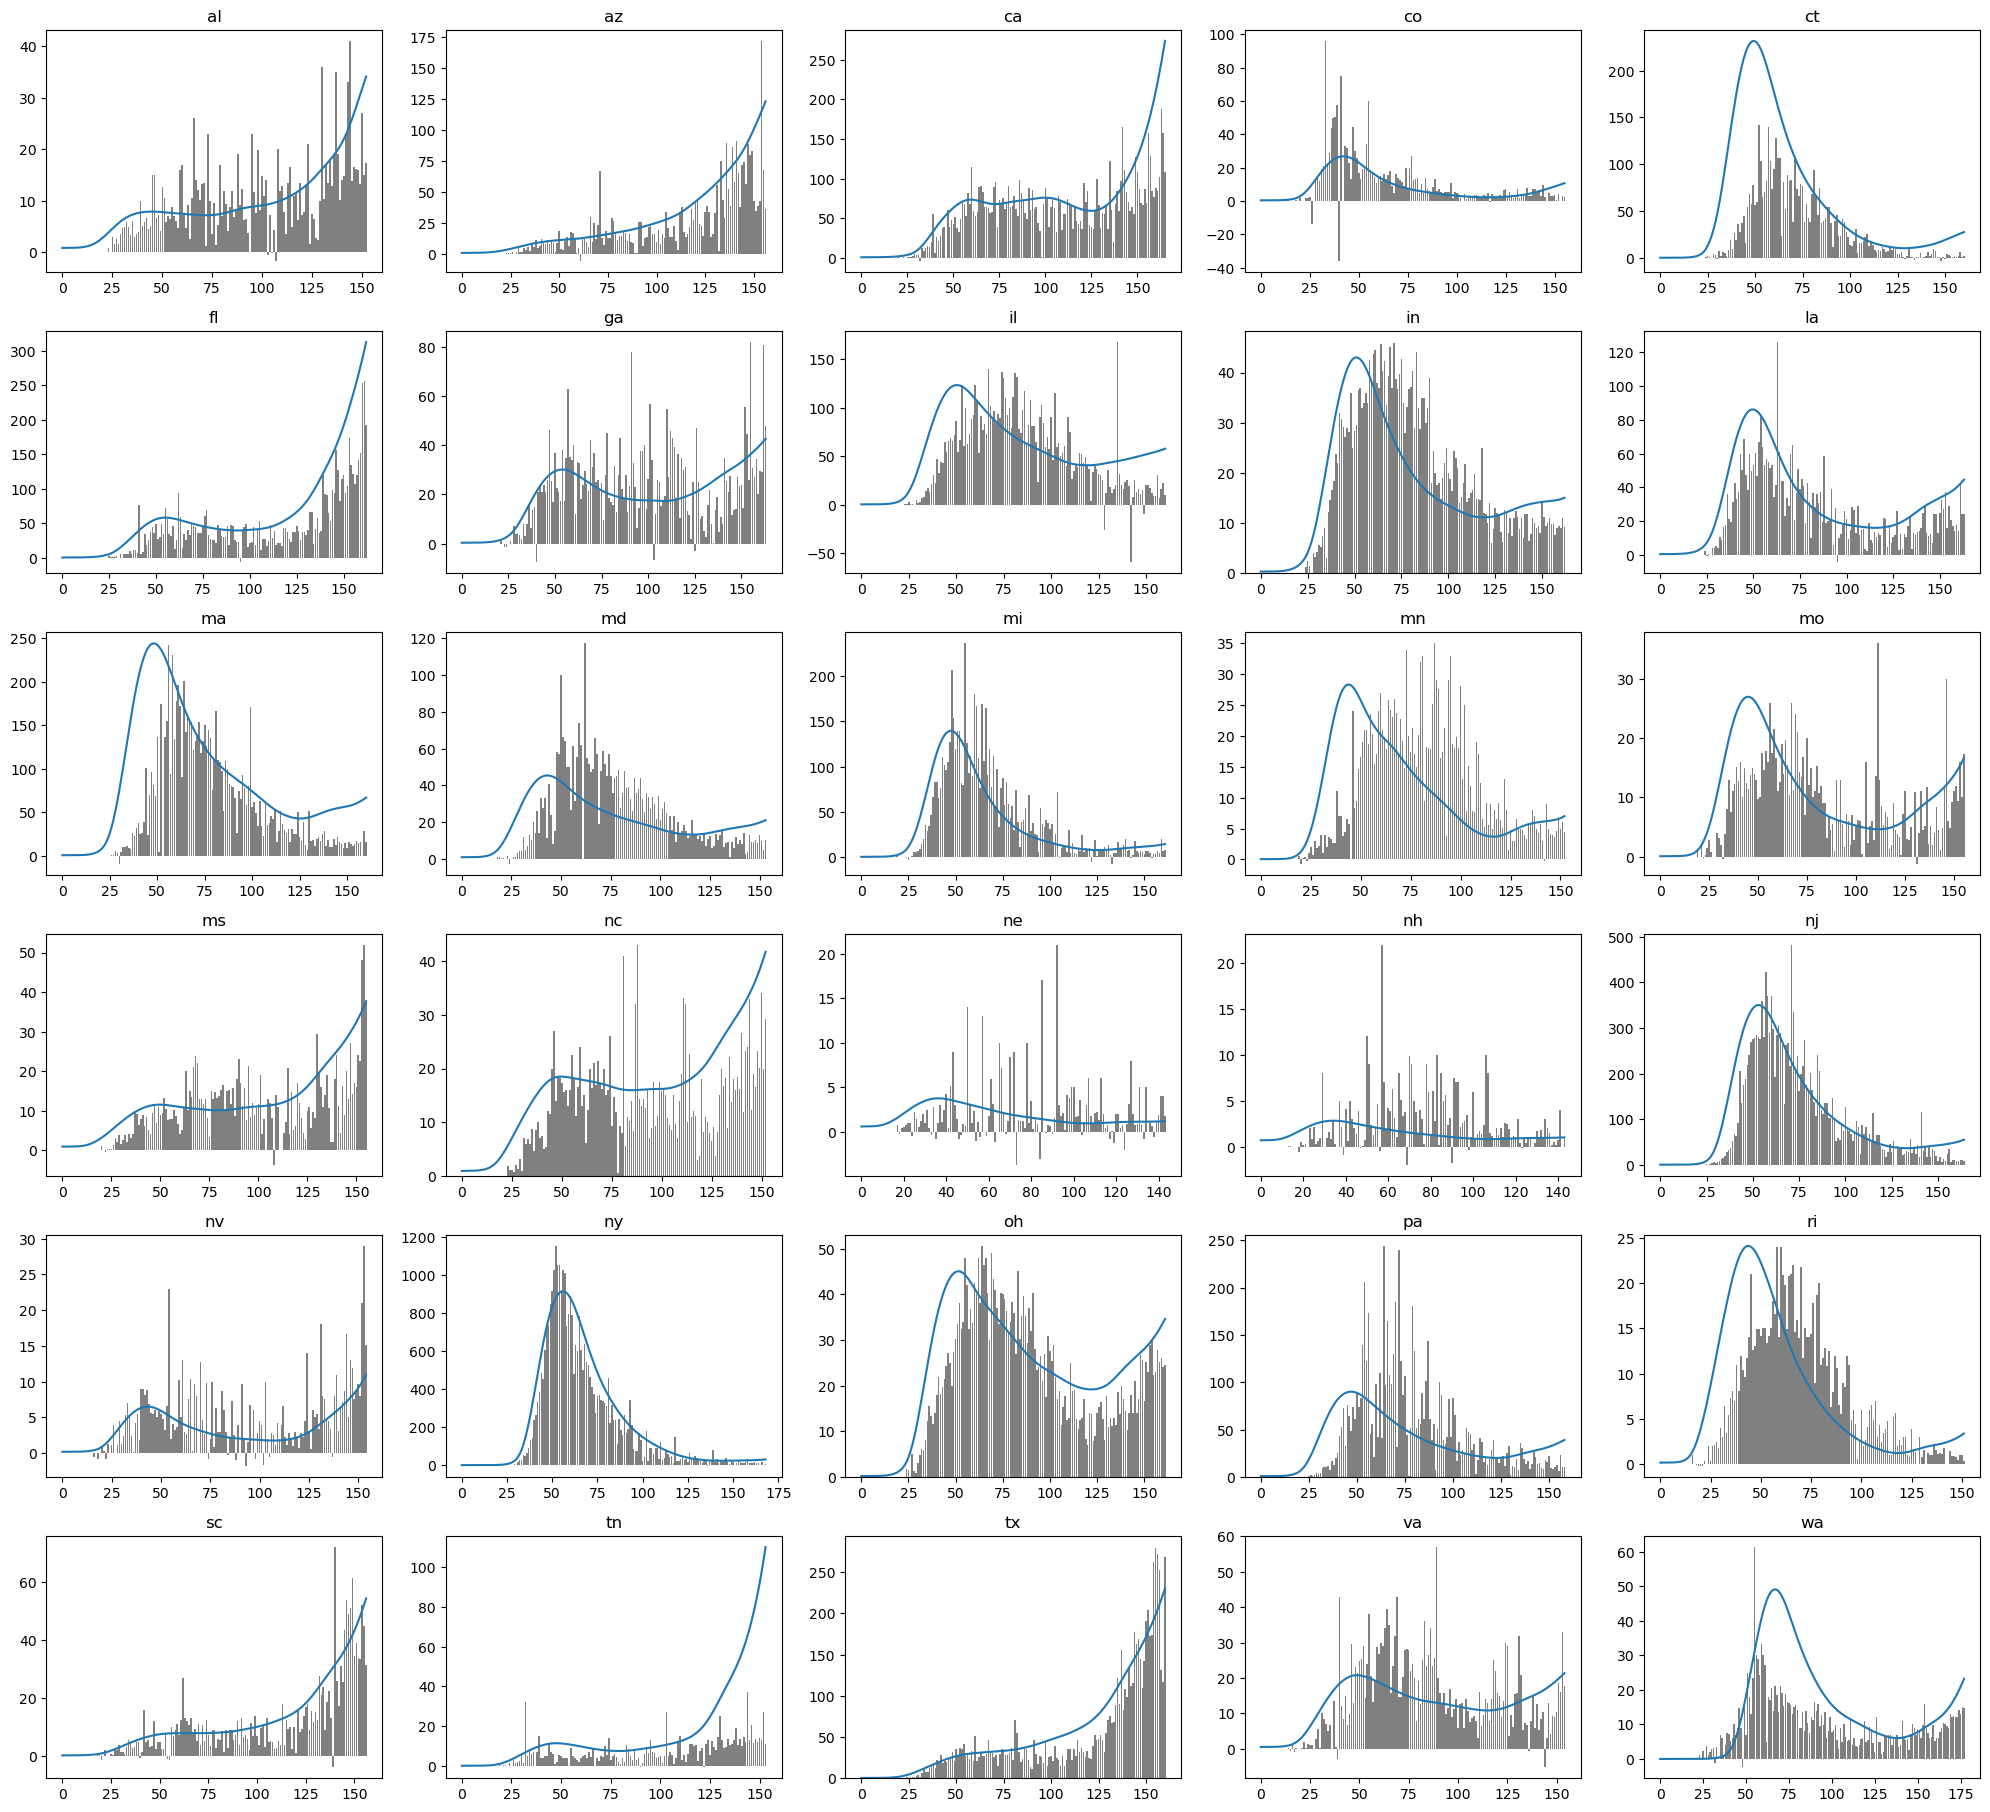

In [504]:
plt.figure(figsize=(20, int(len(regions)/5+1)*3))

for i, r in enumerate(regions):
    plt.subplot(int(len(regions)/5+1),5,i+1)
    
    Y = np.array(data[data.geo_value == r].deaths)
    T = Y.shape[0]
    
    A = np.zeros([T, d])
    A[:,0] = np.full(T, 1)
    A[:,1:] = np.array(data[data.geo_value == r].iloc[:,ivs]) * (-20) + 1.6

    plt.bar(np.arange(T), Y, color='grey')
    plt.plot(model.predict_EY(A, ths_ns[i,0], ths_ns[i,1:]))
    plt.title('%s'%r)
    
plt.tight_layout()

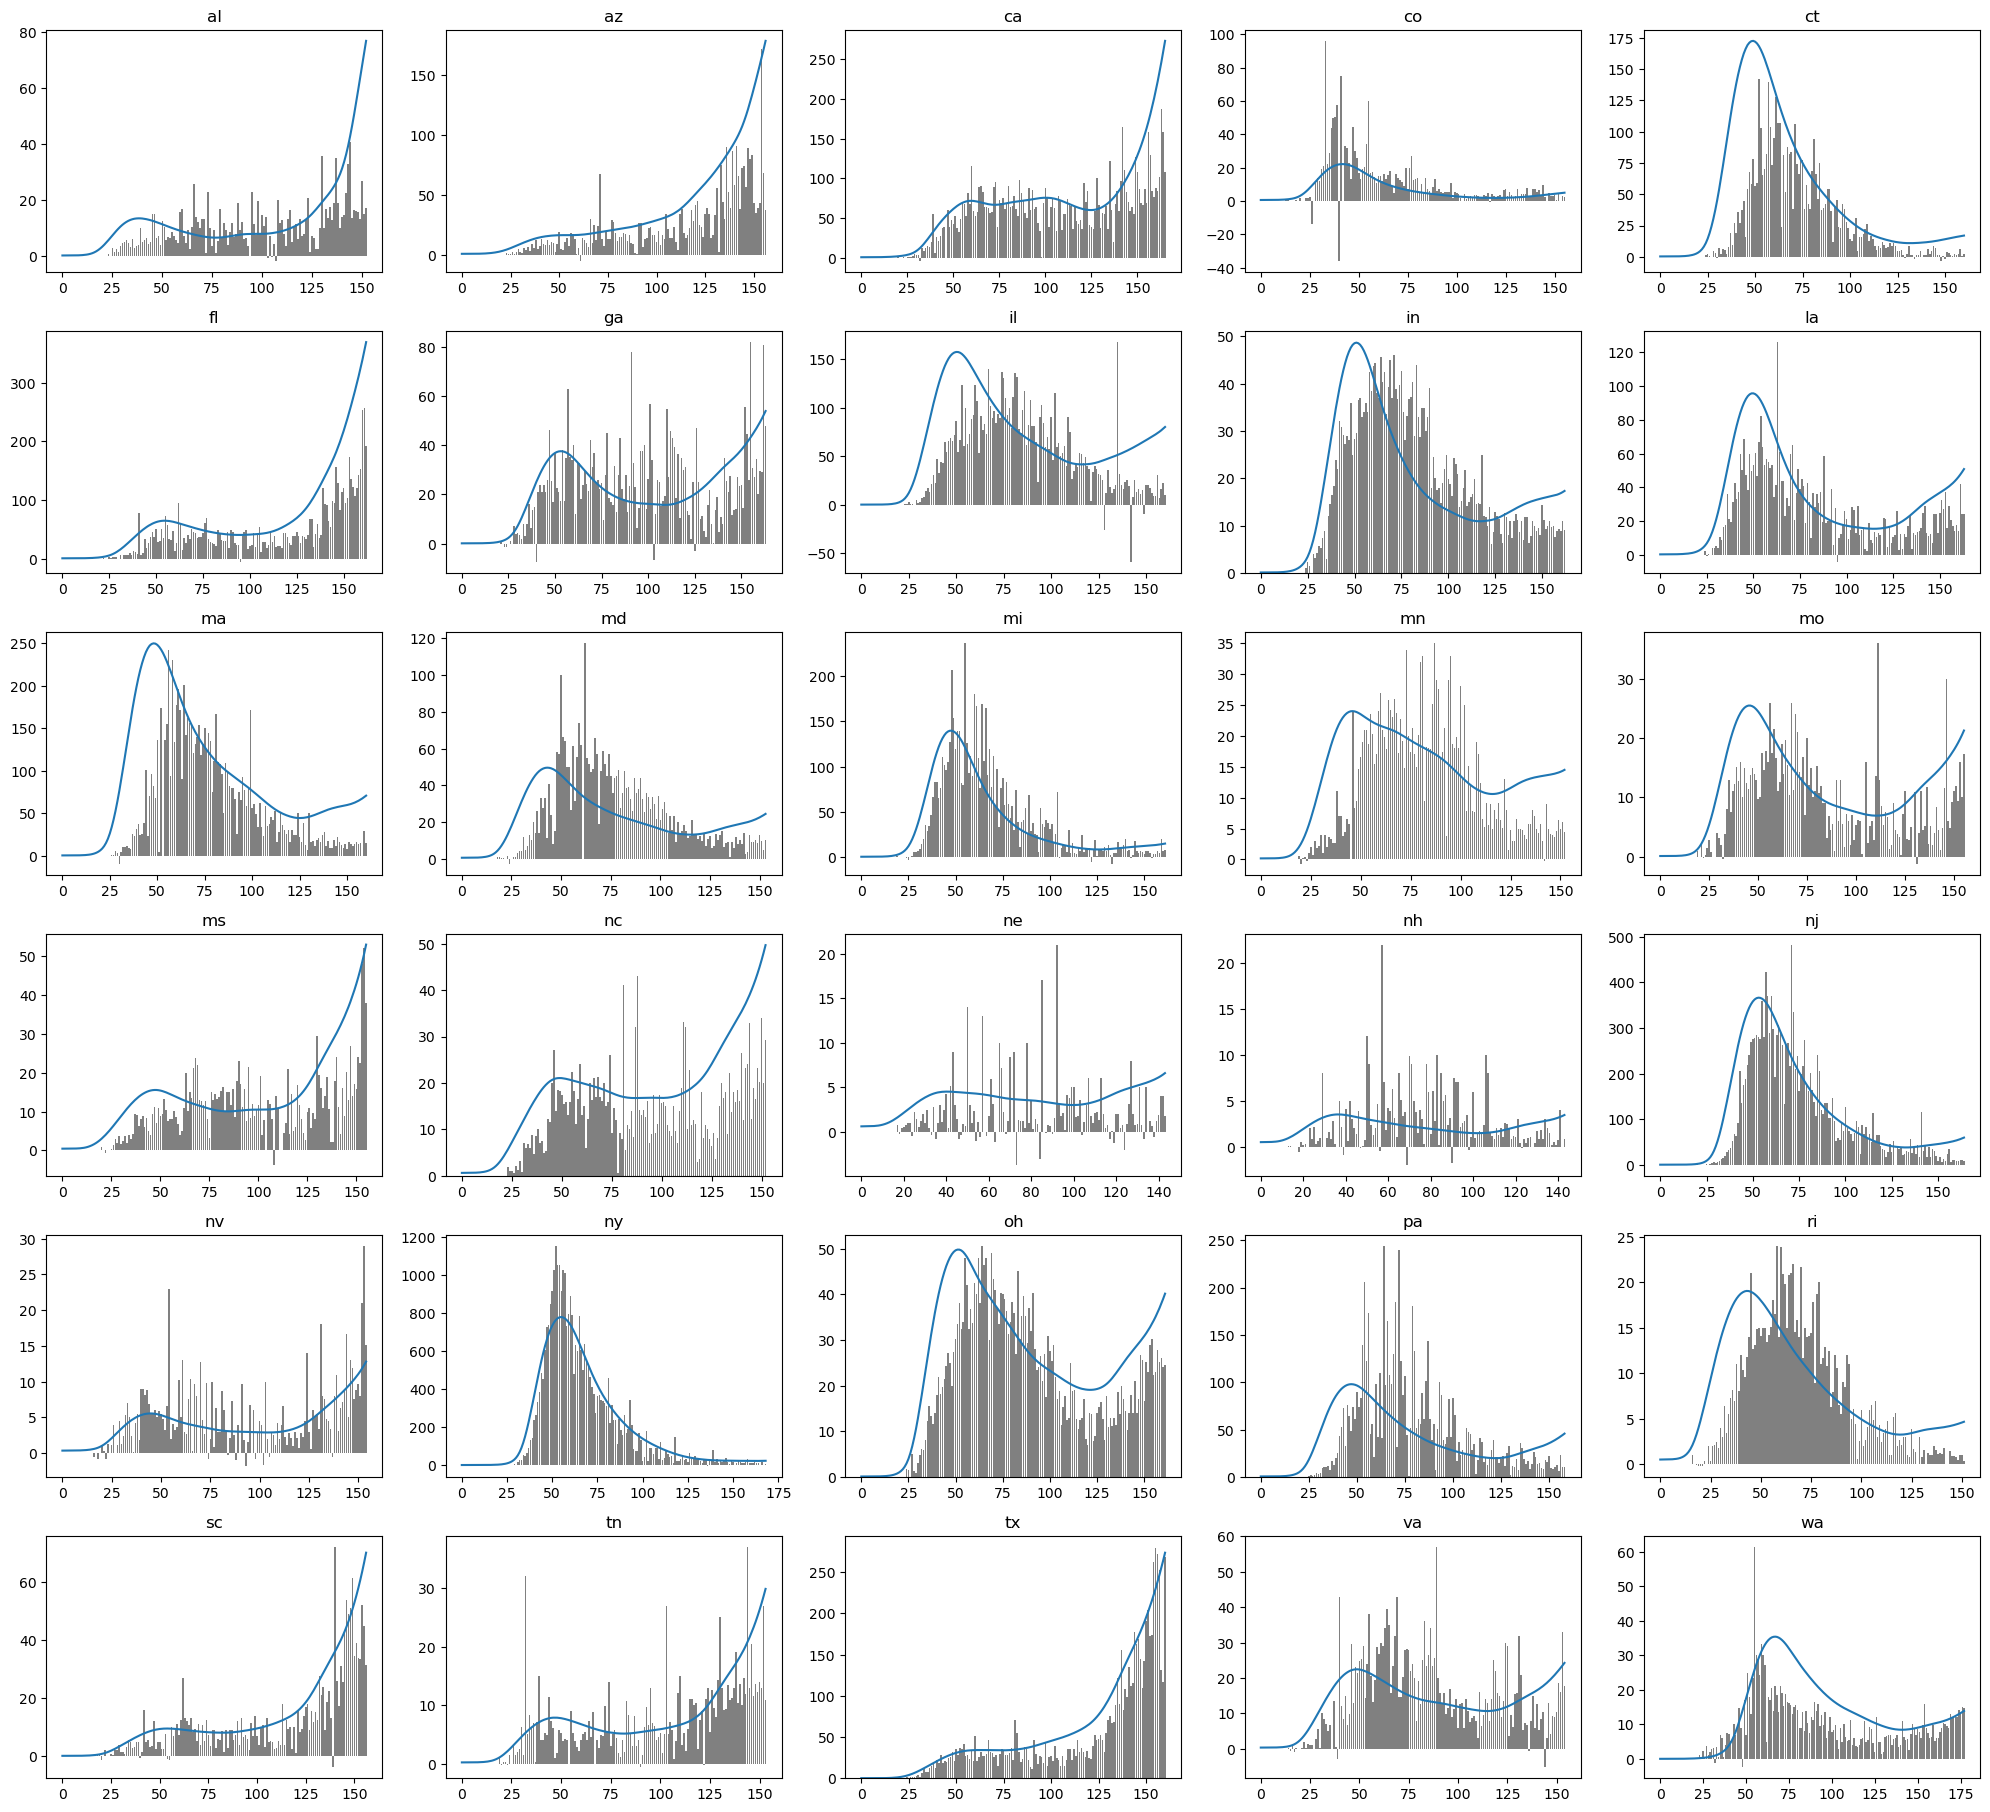

In [505]:
plt.figure(figsize=(20, int(len(regions)/5+1)*3))

for i, r in enumerate(regions):
    plt.subplot(int(len(regions)/5+1),5,i+1)
    
    Y = np.array(data[data.geo_value == r].deaths)
    T = Y.shape[0]
    
    A = np.zeros([T, d])
    A[:,0] = np.full(T, 1)
    A[:,1:] = np.array(data[data.geo_value == r].iloc[:,ivs]) * (-20) + 1.6

    plt.bar(np.arange(T), Y, color='grey')
    plt.plot(model.predict_EY(A, ths_epi[i,0], ths_epi[i,1:]))
    plt.title('%s'%r)
    
plt.tight_layout()

# 4. Causal Forecasting

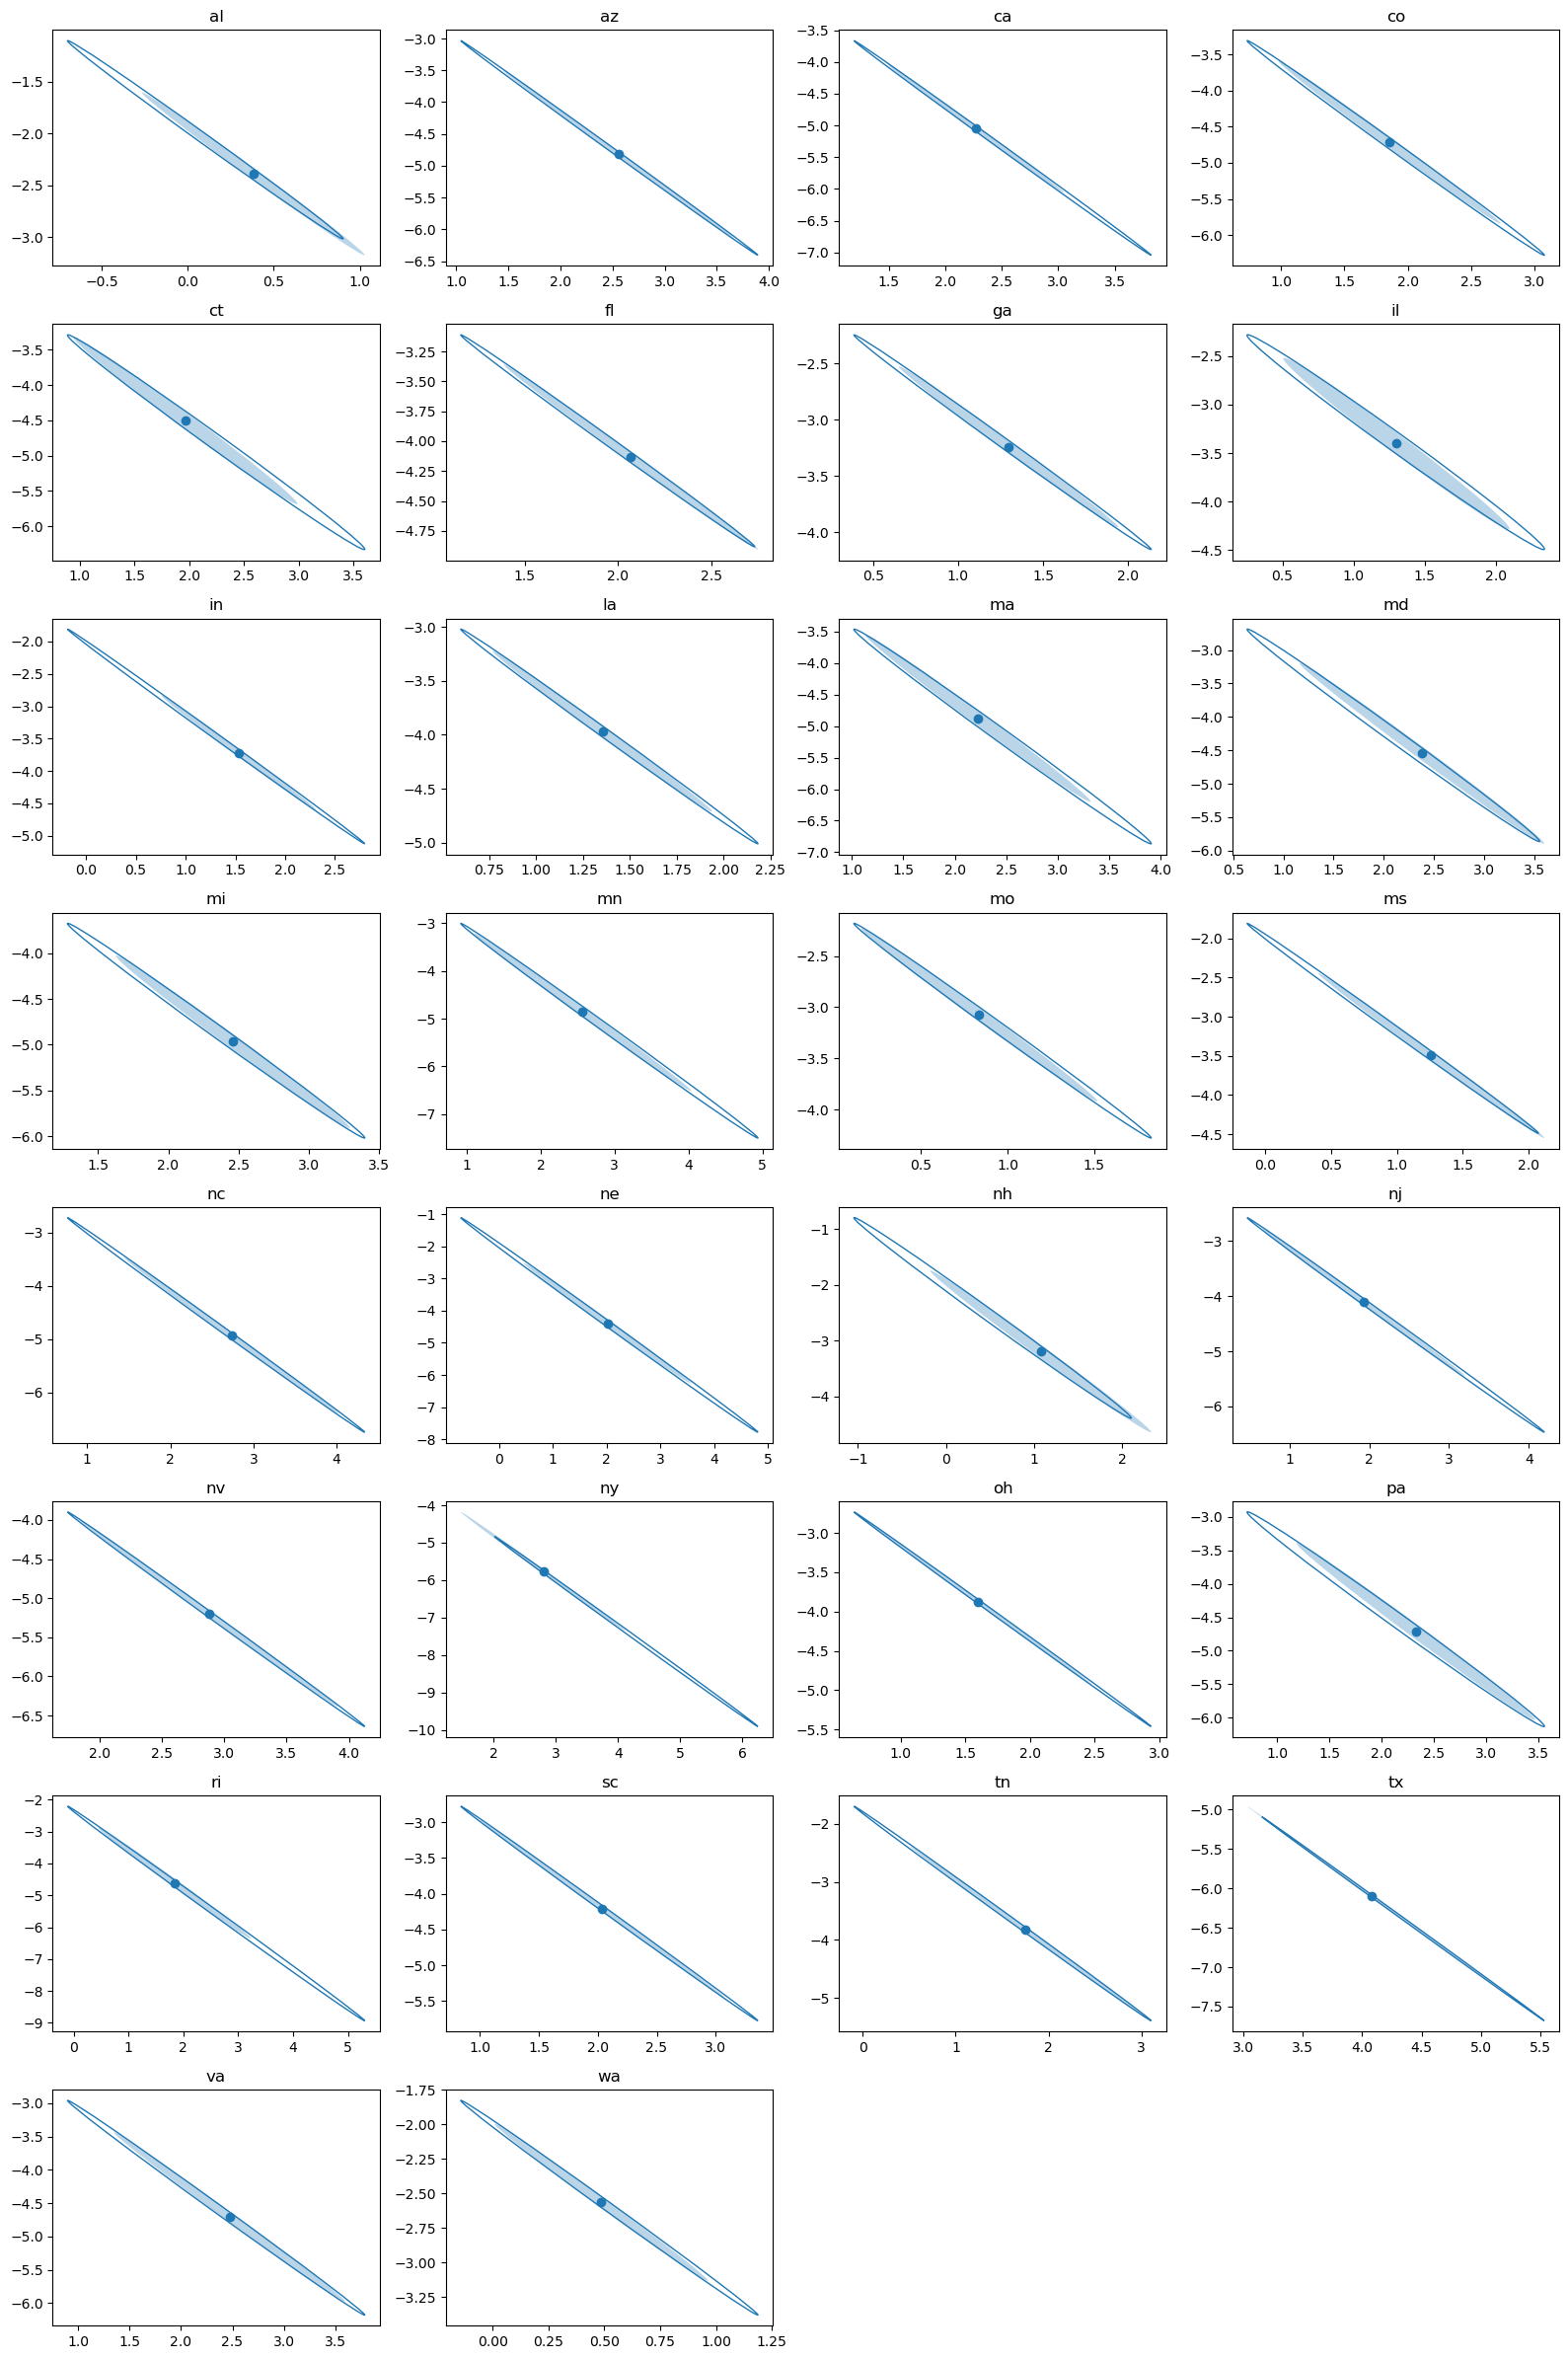

In [59]:
plt.figure(figsize=(16,int(num_region/4+1)*3))
for i, r in enumerate(regions):
    plt.subplot(int(num_region/4+1),4,i+1)
    
    p = plt.scatter(ths_eb[i,1], ths_eb[i,2])
    freqepid.confidence_ellipse(
        ths_eb[i,1:], covs_eb[i,1:,1:], n_std = chi_eb[i],
        facecolor=p.get_facecolor(), alpha=0.3)
    freqepid.confidence_ellipse(
        thats[i,1:], covs[i,1:,1:], n_std = chi_pa,
        edgecolor=p.get_facecolor(), facecolor='none', alpha=1)
    
    plt.title('%s'%r)
plt.tight_layout()

## NY 

In [96]:
i = 21
r = regions[i]

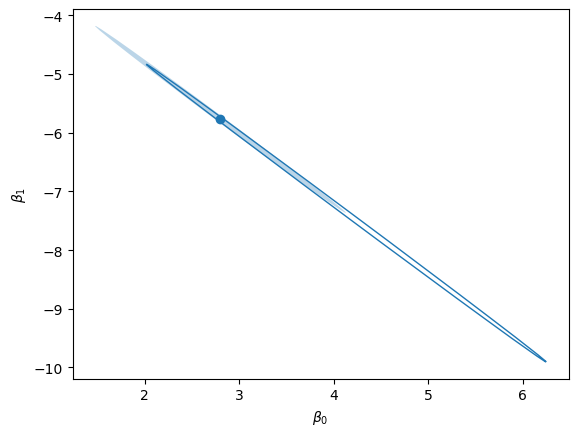

In [98]:
p = plt.scatter(ths_eb[i,1], ths_eb[i,2])
freqepid.confidence_ellipse(
    ths_eb[i,1:], Vs_eb[i,1:,1:], n_std = chi_eb[i],
    facecolor=p.get_facecolor(), alpha=0.3)
freqepid.confidence_ellipse(
    ths_mle[i,1:], Vs_mle[i,1:,1:], n_std = chi_pa,
    edgecolor=p.get_facecolor(), facecolor='none', alpha=1)
plt.xlabel(r"$\beta_0$"); plt.ylabel(r"$\beta_1$"); #plt.legend(loc=(1.02,0))

In [99]:
Y = np.array(data[data.geo_value == r].deaths)
T = Y.shape[0]

A = np.zeros([T, d])
A[:,0] = np.full(T, 1)
A[:,1:] = np.array(data[data.geo_value == r].iloc[:,ivs]) * (-20) + 1.6

In [101]:
Tf = 60

Text(0, 0.5, 'intervention')

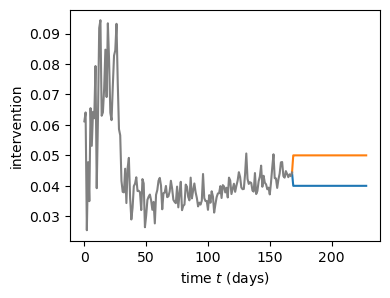

In [102]:
plt.figure(figsize=(4,3))
plt.plot(np.arange(T-1, T+Tf), np.concatenate([(A[:,1] - 1.6) / (-20), np.full(Tf, 0.04)])[T-1:])
plt.plot(np.arange(T-1, T+Tf), np.concatenate([(A[:,1] - 1.6) / (-20), np.full(Tf, 0.05)])[T-1:])
plt.plot((A[:,1] - 1.6)/(-20), color='grey')
plt.xlabel("time $t$ (days)"); plt.ylabel("intervention")

## A = 0.5

In [103]:
Af = np.zeros([Tf, d])
Af[:,0] = np.full(Tf, 1)
Af[:,1] = np.full(Tf, 0.05 * (-20) + 1.6)

In [104]:
Ae = np.concatenate([A, Af], 0)

(0.0, 4000.0)

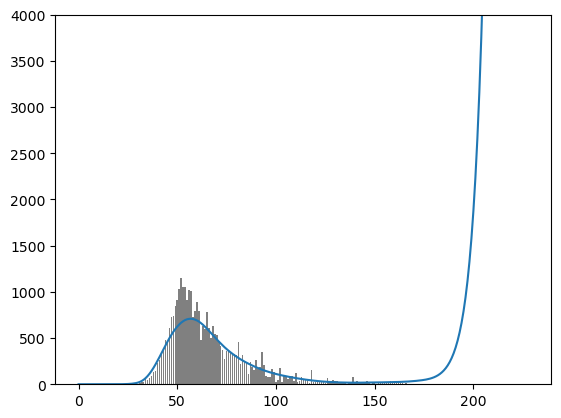

In [107]:
plt.bar(np.arange(T), Y, color='grey')
plt.plot(model.predict_EY(Ae, ths_mle[i,0], ths_mle[i,1:]))
# plt.fill_between(np.arange(T+Tf),
#                  conf_pa[:,0], conf_pa[:,1], alpha=0.3)
plt.ylim(0,4000)

## vanilla CR

In [167]:
conf_pa, _, _ = \
model.confidence_EY(Ae, ths_mle[i,0], ths_mle[i,1:],
                    Vs_mle[i], chi_pa, verbose=True)

optimization at t = 1 finished, lapse: 2.754sec.
optimization at t = 2 finished, lapse: 2.693sec.


/Users/blueconet/mambaforge/envs/freqepid/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


optimization at t = 3 finished, lapse: 2.754sec.
optimization at t = 4 finished, lapse: 2.775sec.
optimization at t = 5 finished, lapse: 2.787sec.
optimization at t = 6 finished, lapse: 2.797sec.
optimization at t = 7 finished, lapse: 2.778sec.
optimization at t = 8 finished, lapse: 2.789sec.
optimization at t = 9 finished, lapse: 2.783sec.
optimization at t = 10 finished, lapse: 2.794sec.
optimization at t = 11 finished, lapse: 2.782sec.
optimization at t = 12 finished, lapse: 2.755sec.
optimization at t = 13 finished, lapse: 2.734sec.
optimization at t = 14 finished, lapse: 2.649sec.
optimization at t = 15 finished, lapse: 2.669sec.
optimization at t = 16 finished, lapse: 2.696sec.
optimization at t = 17 finished, lapse: 2.707sec.
optimization at t = 18 finished, lapse: 2.549sec.
optimization at t = 19 finished, lapse: 1.691sec.
optimization at t = 20 finished, lapse: 1.682sec.
optimization at t = 21 finished, lapse: 1.853sec.
optimization at t = 22 finished, lapse: 1.408sec.
optimiz

optimization at t = 166 finished, lapse: 2.075sec.
optimization at t = 167 finished, lapse: 2.338sec.
optimization at t = 168 finished, lapse: 4.126sec.
optimization at t = 169 finished, lapse: 2.214sec.
optimization at t = 170 finished, lapse: 1.869sec.
optimization at t = 171 finished, lapse: 1.874sec.
optimization at t = 172 finished, lapse: 1.675sec.
optimization at t = 173 finished, lapse: 2.583sec.
optimization at t = 174 finished, lapse: 2.237sec.
optimization at t = 175 finished, lapse: 2.882sec.
optimization at t = 176 finished, lapse: 2.683sec.
optimization at t = 177 finished, lapse: 1.219sec.
optimization at t = 178 finished, lapse: 1.975sec.
optimization at t = 179 finished, lapse: 2.691sec.
optimization at t = 180 finished, lapse: 3.111sec.
optimization at t = 181 finished, lapse: 1.836sec.
optimization at t = 182 finished, lapse: 3.324sec.
optimization at t = 183 finished, lapse: 2.609sec.
optimization at t = 184 finished, lapse: 2.730sec.
optimization at t = 185 finishe

KeyboardInterrupt: 

## EBCR

In [ ]:
conf_eb, _, _ = \
model.confidence_EY(Ae, ths_eb[i,0], ths_eb[i,1:],
                    Vs_eb[i], chi_eb[i], verbose=True)

In [ ]:
np.savez("counterfactual_freqepid_delphi_%s_05.npz"%r,
         Ae = Ae, th_pa = ths_mle[i], conf_pa = conf_pa,
         th_eb = ths_eb[i], conf_eb = conf_eb)

## plot

In [191]:
locals().update(np.load(
    "counterfactual_freqepid_delphi_%s_05.npz"%r))

(0.0, 4000.0)

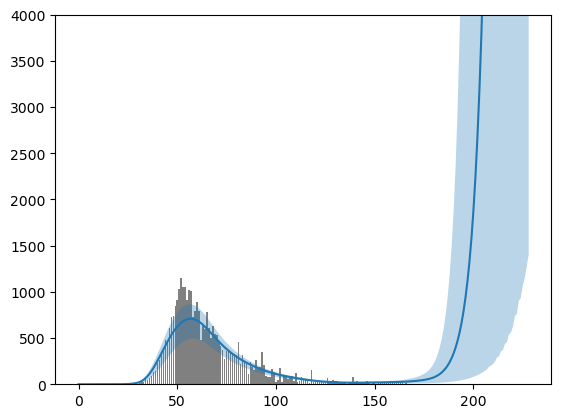

In [192]:
plt.bar(np.arange(T), Y, color='grey')
plt.plot(model.predict_EY(Ae, th_pa[0], th_pa[1:]))
plt.fill_between(np.arange(T+Tf),
                 conf_pa[:,0], conf_pa[:,1], alpha=0.3)
plt.ylim(0,4000)

Text(0, 0.5, 'deaths')

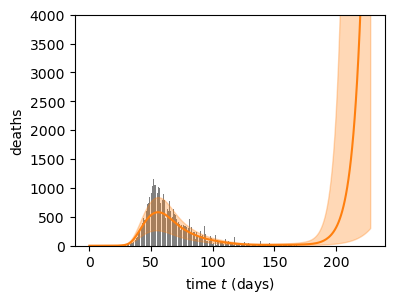

In [193]:
plt.figure(figsize=(4,3))
plt.bar(np.arange(T), Y, color='grey')
plt.plot(model.predict_EY(Ae, th_eb[0], th_eb[1:]), color='C1')
plt.fill_between(np.arange(T+Tf),
                 conf_eb[:,0], conf_eb[:,1], alpha=0.3, color='C1')
# plt.fill_between(np.arange(T+Tf),
#                  conf_pa[:,0], conf_pa[:,1], color='grey', alpha=0.3)
# plt.plot(conf_pa[:,0], color='C0', alpha=0.5)
# plt.plot(conf_pa[:,1], color='C0', alpha=0.5)
plt.ylim(0,4000)
plt.xlabel("time $t$ (days)"); plt.ylabel("deaths")

## intervention = 0.045

In [91]:
Tf = 60
Af = np.zeros([Tf, d])

In [92]:
Af[:,0] = np.full(Tf, 1)
Af[:,1] = np.full(Tf, 0.045 * (-20) + 1.6)

In [93]:
Ae = np.concatenate([A, Af], 0)

(0.0, 4000.0)

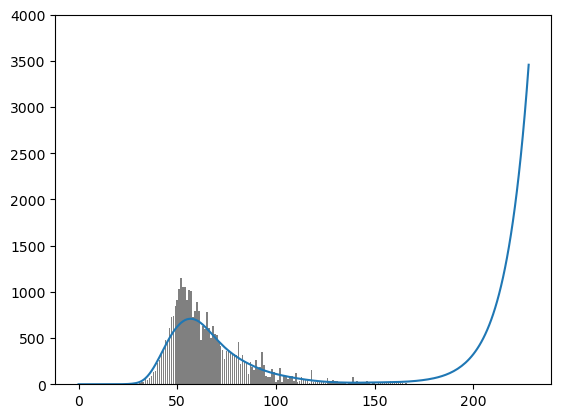

In [94]:
plt.bar(np.arange(T), Y, color='grey')
plt.plot(model.predict_EY(Ae, thats[i,0], thats[i,1:]))
# plt.fill_between(np.arange(T+Tf),
#                  conf_pa[:,0], conf_pa[:,1], alpha=0.3)
plt.ylim(0,4000)

## vanilla CR

In [95]:
conf_pa, _, _ = \
model.confidence_EY(Ae, thats[i,0], thats[i,1:],
                    covs[i], chi_pa, verbose=True)

optimization at t = 1 finished, lapse: 2.730sec.
optimization at t = 2 finished, lapse: 2.678sec.


/Users/blueconet/mambaforge/envs/freqepid/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


optimization at t = 3 finished, lapse: 2.739sec.
optimization at t = 4 finished, lapse: 2.758sec.
optimization at t = 5 finished, lapse: 2.726sec.
optimization at t = 6 finished, lapse: 2.794sec.
optimization at t = 7 finished, lapse: 2.729sec.
optimization at t = 8 finished, lapse: 2.740sec.
optimization at t = 9 finished, lapse: 2.740sec.
optimization at t = 10 finished, lapse: 2.761sec.
optimization at t = 11 finished, lapse: 2.763sec.
optimization at t = 12 finished, lapse: 2.705sec.
optimization at t = 13 finished, lapse: 2.744sec.
optimization at t = 14 finished, lapse: 2.653sec.
optimization at t = 15 finished, lapse: 2.671sec.
optimization at t = 16 finished, lapse: 2.707sec.
optimization at t = 17 finished, lapse: 2.695sec.
optimization at t = 18 finished, lapse: 2.540sec.
optimization at t = 19 finished, lapse: 1.666sec.
optimization at t = 20 finished, lapse: 1.682sec.
optimization at t = 21 finished, lapse: 1.858sec.
optimization at t = 22 finished, lapse: 1.408sec.
optimiz

optimization at t = 166 finished, lapse: 2.729sec.
optimization at t = 167 finished, lapse: 1.861sec.
optimization at t = 168 finished, lapse: 4.626sec.
optimization at t = 169 finished, lapse: 2.708sec.
optimization at t = 170 finished, lapse: 2.043sec.
optimization at t = 171 finished, lapse: 3.190sec.
optimization at t = 172 finished, lapse: 1.560sec.
optimization at t = 173 finished, lapse: 3.043sec.
optimization at t = 174 finished, lapse: 3.479sec.
optimization at t = 175 finished, lapse: 3.326sec.
optimization at t = 176 finished, lapse: 2.822sec.
optimization at t = 177 finished, lapse: 2.465sec.
optimization at t = 178 finished, lapse: 2.534sec.
optimization at t = 179 finished, lapse: 4.971sec.
optimization at t = 180 finished, lapse: 5.278sec.
optimization at t = 181 finished, lapse: 3.300sec.
optimization at t = 182 finished, lapse: 3.232sec.
optimization at t = 183 finished, lapse: 4.202sec.
optimization at t = 184 finished, lapse: 4.573sec.
optimization at t = 185 finishe

## EBCR

In [96]:
conf_eb, _, _ = \
model.confidence_EY(Ae, ths_eb[i,0], ths_eb[i,1:],
                    covs_eb[i], chi_eb[i], verbose=True)

optimization at t = 1 finished, lapse: 2.795sec.
optimization at t = 2 finished, lapse: 2.776sec.
optimization at t = 3 finished, lapse: 2.751sec.
optimization at t = 4 finished, lapse: 2.776sec.
optimization at t = 5 finished, lapse: 2.752sec.
optimization at t = 6 finished, lapse: 2.757sec.
optimization at t = 7 finished, lapse: 2.778sec.
optimization at t = 8 finished, lapse: 2.712sec.
optimization at t = 9 finished, lapse: 2.808sec.
optimization at t = 10 finished, lapse: 2.749sec.
optimization at t = 11 finished, lapse: 2.704sec.
optimization at t = 12 finished, lapse: 2.670sec.
optimization at t = 13 finished, lapse: 2.685sec.
optimization at t = 14 finished, lapse: 2.657sec.
optimization at t = 15 finished, lapse: 2.711sec.
optimization at t = 16 finished, lapse: 2.429sec.
optimization at t = 17 finished, lapse: 1.888sec.
optimization at t = 18 finished, lapse: 2.139sec.
optimization at t = 19 finished, lapse: 1.775sec.
optimization at t = 20 finished, lapse: 1.632sec.
optimizat

optimization at t = 164 finished, lapse: 1.916sec.
optimization at t = 165 finished, lapse: 2.072sec.
optimization at t = 166 finished, lapse: 1.130sec.
optimization at t = 167 finished, lapse: 1.347sec.
optimization at t = 168 finished, lapse: 1.029sec.
optimization at t = 169 finished, lapse: 1.236sec.
optimization at t = 170 finished, lapse: 1.384sec.
optimization at t = 171 finished, lapse: 3.494sec.
optimization at t = 172 finished, lapse: 1.985sec.
optimization at t = 173 finished, lapse: 1.775sec.
optimization at t = 174 finished, lapse: 2.270sec.
optimization at t = 175 finished, lapse: 1.868sec.
optimization at t = 176 finished, lapse: 2.390sec.
optimization at t = 177 finished, lapse: 1.364sec.
optimization at t = 178 finished, lapse: 1.683sec.
optimization at t = 179 finished, lapse: 1.948sec.
optimization at t = 180 finished, lapse: 2.576sec.
optimization at t = 181 finished, lapse: 2.289sec.
optimization at t = 182 finished, lapse: 1.699sec.
optimization at t = 183 finishe

In [97]:
np.savez("counterfactual_freqepid_delphi_%s_045.npz"%regions[i],
         Ae = Ae, th_pa = thats[i], conf_pa = conf_pa,
         th_eb = ths_eb[i], conf_eb = conf_eb)

## plot

In [152]:
locals().update(np.load(
    "counterfactual_freqepid_delphi_%s_045.npz"%regions[i]))

Text(0, 0.5, 'deaths')

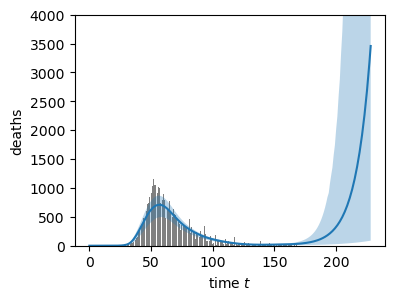

In [153]:
plt.figure(figsize=(4,3))
plt.bar(np.arange(T), Y, color='grey')
plt.plot(model.predict_EY(Ae, th_pa[0], th_pa[1:]))
plt.fill_between(np.arange(T+Tf),
                 conf_pa[:,0], conf_pa[:,1], alpha=0.3)
plt.ylim(0,4000)
plt.xlabel("time $t$"); plt.ylabel("deaths")

Text(0, 0.5, 'deaths')

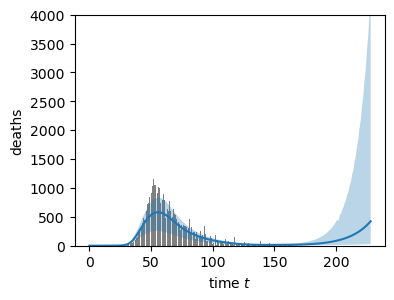

In [154]:
plt.figure(figsize=(4,3))
plt.bar(np.arange(T), Y, color='grey')
plt.plot(model.predict_EY(Ae, th_eb[0], th_eb[1:]))
plt.fill_between(np.arange(T+Tf),
                 conf_eb[:,0], conf_eb[:,1], alpha=0.3)
# plt.plot(conf_pa[:,0], color='C0', alpha=0.5)
# plt.plot(conf_pa[:,1], color='C0', alpha=0.5)
plt.ylim(0,4000)
plt.xlabel("time $t$"); plt.ylabel("deaths")

## intervention = 0.04

In [104]:
Tf = 60
Af = np.zeros([Tf, d])

In [105]:
Af[:,0] = np.full(Tf, 1)
Af[:,1] = np.full(Tf, 0.04*(-20)+1.6)

In [106]:
Ae = np.concatenate([A, Af], 0)

(0.0, 4000.0)

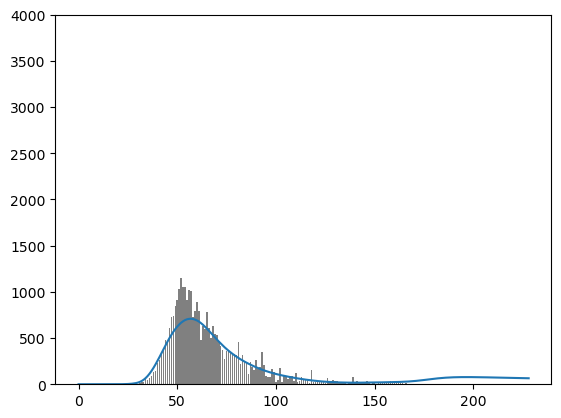

In [107]:
plt.bar(np.arange(T), Y, color='grey')
plt.plot(model.predict_EY(Ae, thats[i,0], thats[i,1:]))
# plt.fill_between(np.arange(T+Tf),
#                  conf_pa[:,0], conf_pa[:,1], alpha=0.3)
plt.ylim(0,4000)

## vanilla CR

In [108]:
conf_pa, _, _ = \
model.confidence_EY(Ae, thats[i,0], thats[i,1:],
                    covs[i], chi_pa, verbose=True)

optimization at t = 1 finished, lapse: 2.722sec.
optimization at t = 2 finished, lapse: 2.693sec.
optimization at t = 3 finished, lapse: 2.723sec.
optimization at t = 4 finished, lapse: 2.750sec.
optimization at t = 5 finished, lapse: 2.755sec.
optimization at t = 6 finished, lapse: 2.808sec.
optimization at t = 7 finished, lapse: 2.772sec.
optimization at t = 8 finished, lapse: 2.787sec.
optimization at t = 9 finished, lapse: 2.772sec.
optimization at t = 10 finished, lapse: 2.791sec.
optimization at t = 11 finished, lapse: 2.769sec.
optimization at t = 12 finished, lapse: 2.725sec.
optimization at t = 13 finished, lapse: 2.731sec.
optimization at t = 14 finished, lapse: 2.661sec.
optimization at t = 15 finished, lapse: 2.680sec.
optimization at t = 16 finished, lapse: 2.753sec.
optimization at t = 17 finished, lapse: 2.706sec.
optimization at t = 18 finished, lapse: 2.559sec.
optimization at t = 19 finished, lapse: 1.673sec.
optimization at t = 20 finished, lapse: 1.680sec.
optimizat

optimization at t = 164 finished, lapse: 6.636sec.
optimization at t = 165 finished, lapse: 2.767sec.
optimization at t = 166 finished, lapse: 2.027sec.
optimization at t = 167 finished, lapse: 1.781sec.
optimization at t = 168 finished, lapse: 4.019sec.
optimization at t = 169 finished, lapse: 2.125sec.
optimization at t = 170 finished, lapse: 1.895sec.
optimization at t = 171 finished, lapse: 2.884sec.
optimization at t = 172 finished, lapse: 2.641sec.
optimization at t = 173 finished, lapse: 2.854sec.
optimization at t = 174 finished, lapse: 2.810sec.
optimization at t = 175 finished, lapse: 2.197sec.
optimization at t = 176 finished, lapse: 1.820sec.
optimization at t = 177 finished, lapse: 1.682sec.
optimization at t = 178 finished, lapse: 1.670sec.
optimization at t = 179 finished, lapse: 1.068sec.
optimization at t = 180 finished, lapse: 3.065sec.
optimization at t = 181 finished, lapse: 3.324sec.
optimization at t = 182 finished, lapse: 4.079sec.
optimization at t = 183 finishe

## EBCR

In [109]:
conf_eb, _, _ = \
model.confidence_EY(Ae, ths_eb[i,0], ths_eb[i,1:],
                    covs_eb[i], chi_eb[i], verbose=True)

optimization at t = 1 finished, lapse: 2.758sec.
optimization at t = 2 finished, lapse: 2.728sec.
optimization at t = 3 finished, lapse: 2.800sec.
optimization at t = 4 finished, lapse: 2.760sec.
optimization at t = 5 finished, lapse: 2.790sec.
optimization at t = 6 finished, lapse: 2.807sec.
optimization at t = 7 finished, lapse: 2.820sec.
optimization at t = 8 finished, lapse: 2.817sec.
optimization at t = 9 finished, lapse: 2.901sec.
optimization at t = 10 finished, lapse: 2.829sec.
optimization at t = 11 finished, lapse: 2.832sec.
optimization at t = 12 finished, lapse: 2.776sec.
optimization at t = 13 finished, lapse: 2.802sec.
optimization at t = 14 finished, lapse: 2.773sec.
optimization at t = 15 finished, lapse: 2.782sec.
optimization at t = 16 finished, lapse: 2.564sec.
optimization at t = 17 finished, lapse: 1.952sec.
optimization at t = 18 finished, lapse: 2.214sec.
optimization at t = 19 finished, lapse: 1.860sec.
optimization at t = 20 finished, lapse: 1.707sec.
optimizat

optimization at t = 164 finished, lapse: 1.963sec.
optimization at t = 165 finished, lapse: 2.171sec.
optimization at t = 166 finished, lapse: 1.219sec.
optimization at t = 167 finished, lapse: 1.541sec.
optimization at t = 168 finished, lapse: 1.458sec.
optimization at t = 169 finished, lapse: 1.847sec.
optimization at t = 170 finished, lapse: 1.743sec.
optimization at t = 171 finished, lapse: 2.539sec.
optimization at t = 172 finished, lapse: 1.200sec.
optimization at t = 173 finished, lapse: 2.278sec.
optimization at t = 174 finished, lapse: 1.879sec.
optimization at t = 175 finished, lapse: 2.004sec.
optimization at t = 176 finished, lapse: 3.429sec.
optimization at t = 177 finished, lapse: 2.545sec.
optimization at t = 178 finished, lapse: 1.309sec.
optimization at t = 179 finished, lapse: 3.098sec.
optimization at t = 180 finished, lapse: 2.433sec.
optimization at t = 181 finished, lapse: 2.381sec.
optimization at t = 182 finished, lapse: 3.593sec.
optimization at t = 183 finishe

In [158]:
np.savez("counterfactual_freqepid_delphi_%s_04.npz"%r,
         Ae = Ae, th_pa = thats[i], conf_pa = conf_pa,
         th_eb = ths_eb[i], conf_eb = conf_eb)

## plot

In [194]:
locals().update(np.load(
    "counterfactual_freqepid_delphi_%s_04.npz"%r))

(0.0, 4000.0)

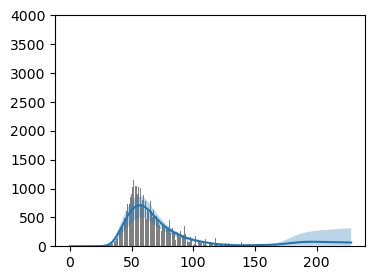

In [195]:
plt.figure(figsize=(4,3))
plt.bar(np.arange(T), Y, color='grey')
plt.plot(model.predict_EY(Ae, th_pa[0], th_pa[1:]))
plt.fill_between(np.arange(T+Tf),
                 conf_pa[:,0], conf_pa[:,1], alpha=0.3)
plt.ylim(0,4000)

Text(0, 0.5, 'deaths')

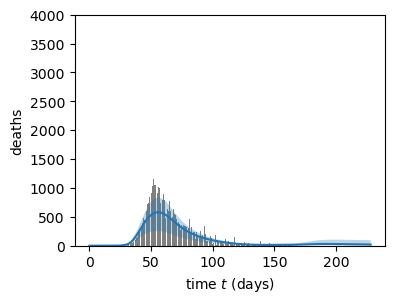

In [197]:
plt.figure(figsize=(4,3))
plt.bar(np.arange(T), Y, color='grey')
plt.plot(model.predict_EY(Ae, th_eb[0], th_eb[1:]))
plt.fill_between(np.arange(T+Tf),
                 conf_eb[:,0], conf_eb[:,1], alpha=0.3)
# plt.plot(conf_pa[:,0], color='C0', linewidth=1, linestyle='--')
# plt.plot(conf_pa[:,1], color='C0', linewidth=1, linestyle='--')
plt.ylim(0,4000)
plt.xlabel("time $t$ (days)"); plt.ylabel("deaths")

# 5. Natural interventions

In [287]:
Af_dec = A[:-61:-1,1]*(1 + np.linspace(0,0.2,60))
Af_inc = A[-60:,1]+A[-1,1]-A[-61,1]

Text(0, 0.5, 'intervention')

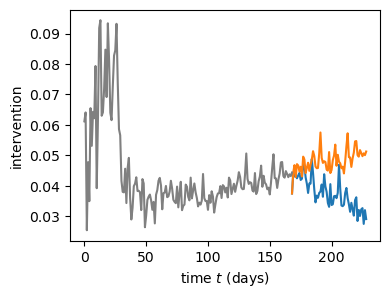

In [289]:
plt.figure(figsize=(4,3))
plt.plot(np.arange(T-1, T+Tf), (np.concatenate([[A[-61,1]], Af_dec]) - 1.6) / (-20))
plt.plot(np.arange(T-1, T+Tf), (np.concatenate([[A[-61,1]], Af_inc]) - 1.6) / (-20))
plt.plot((A[:,1] - 1.6)/(-20), color='grey')
plt.xlabel("time $t$ (days)"); plt.ylabel("intervention")

## decreasing intervention

In [290]:
Tf = 60
Af = np.zeros([Tf, d])

In [291]:
A.shape

(169, 2)

In [308]:
Af[:,0] = np.full(Tf, 1)
Af[:,1] = Af_dec

In [309]:
Ae = np.concatenate([A, Af], 0)

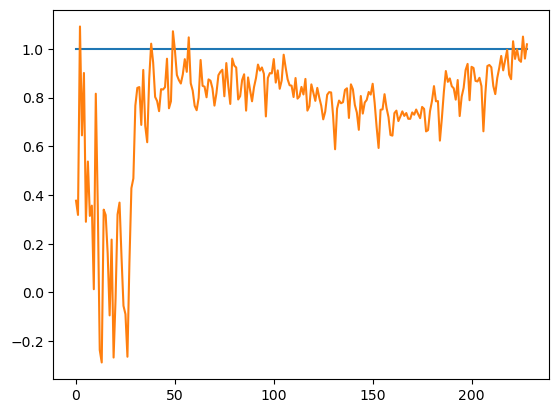

In [310]:
plt.plot(Ae)

(0.0, 4000.0)

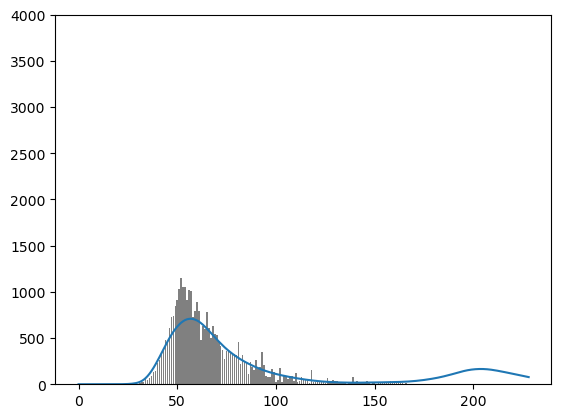

In [311]:
plt.bar(np.arange(T), Y, color='grey')
plt.plot(model.predict_EY(Ae, thats[i,0], thats[i,1:]))
# plt.fill_between(np.arange(T+Tf),
#                  conf_pa[:,0], conf_pa[:,1], alpha=0.3)
plt.ylim(0,4000)

## vanilla CR

In [272]:
conf_pa, _, _ = \
model.confidence_EY(Ae, thats[i,0], thats[i,1:],
                    covs[i], chi_pa, verbose=True)

optimization at t = 1 finished, lapse: 2.785sec.
optimization at t = 2 finished, lapse: 2.684sec.
optimization at t = 3 finished, lapse: 2.724sec.
optimization at t = 4 finished, lapse: 2.728sec.
optimization at t = 5 finished, lapse: 2.778sec.
optimization at t = 6 finished, lapse: 2.731sec.
optimization at t = 7 finished, lapse: 2.707sec.
optimization at t = 8 finished, lapse: 2.724sec.
optimization at t = 9 finished, lapse: 2.711sec.
optimization at t = 10 finished, lapse: 2.735sec.
optimization at t = 11 finished, lapse: 2.736sec.
optimization at t = 12 finished, lapse: 2.674sec.
optimization at t = 13 finished, lapse: 2.766sec.
optimization at t = 14 finished, lapse: 2.647sec.
optimization at t = 15 finished, lapse: 2.668sec.
optimization at t = 16 finished, lapse: 2.687sec.
optimization at t = 17 finished, lapse: 2.683sec.
optimization at t = 18 finished, lapse: 2.554sec.
optimization at t = 19 finished, lapse: 1.675sec.
optimization at t = 20 finished, lapse: 1.686sec.
optimizat

optimization at t = 164 finished, lapse: 6.713sec.
optimization at t = 165 finished, lapse: 2.811sec.
optimization at t = 166 finished, lapse: 1.908sec.
optimization at t = 167 finished, lapse: 1.758sec.
optimization at t = 168 finished, lapse: 4.519sec.
optimization at t = 169 finished, lapse: 2.732sec.
optimization at t = 170 finished, lapse: 2.505sec.
optimization at t = 171 finished, lapse: 2.416sec.
optimization at t = 172 finished, lapse: 2.599sec.
optimization at t = 173 finished, lapse: 2.192sec.
optimization at t = 174 finished, lapse: 2.346sec.
optimization at t = 175 finished, lapse: 2.747sec.
optimization at t = 176 finished, lapse: 2.358sec.
optimization at t = 177 finished, lapse: 2.331sec.
optimization at t = 178 finished, lapse: 2.826sec.
optimization at t = 179 finished, lapse: 1.991sec.
optimization at t = 180 finished, lapse: 3.233sec.
optimization at t = 181 finished, lapse: 2.675sec.
optimization at t = 182 finished, lapse: 3.150sec.
optimization at t = 183 finishe

## EBCR

In [273]:
conf_eb, _, _ = \
model.confidence_EY(Ae, ths_eb[i,0], ths_eb[i,1:],
                    covs_eb[i], chi_eb[i], verbose=True)

optimization at t = 1 finished, lapse: 2.763sec.
optimization at t = 2 finished, lapse: 2.742sec.
optimization at t = 3 finished, lapse: 2.753sec.
optimization at t = 4 finished, lapse: 2.769sec.
optimization at t = 5 finished, lapse: 2.757sec.
optimization at t = 6 finished, lapse: 2.765sec.
optimization at t = 7 finished, lapse: 2.736sec.
optimization at t = 8 finished, lapse: 2.731sec.
optimization at t = 9 finished, lapse: 2.790sec.
optimization at t = 10 finished, lapse: 2.723sec.
optimization at t = 11 finished, lapse: 2.711sec.
optimization at t = 12 finished, lapse: 2.665sec.
optimization at t = 13 finished, lapse: 2.672sec.
optimization at t = 14 finished, lapse: 2.642sec.
optimization at t = 15 finished, lapse: 2.663sec.
optimization at t = 16 finished, lapse: 2.434sec.
optimization at t = 17 finished, lapse: 1.855sec.
optimization at t = 18 finished, lapse: 2.114sec.
optimization at t = 19 finished, lapse: 1.770sec.
optimization at t = 20 finished, lapse: 1.629sec.
optimizat

optimization at t = 164 finished, lapse: 2.017sec.
optimization at t = 165 finished, lapse: 2.135sec.
optimization at t = 166 finished, lapse: 1.233sec.
optimization at t = 167 finished, lapse: 1.484sec.
optimization at t = 168 finished, lapse: 1.016sec.
optimization at t = 169 finished, lapse: 1.187sec.
optimization at t = 170 finished, lapse: 1.398sec.
optimization at t = 171 finished, lapse: 3.394sec.
optimization at t = 172 finished, lapse: 2.368sec.
optimization at t = 173 finished, lapse: 1.680sec.
optimization at t = 174 finished, lapse: 1.650sec.
optimization at t = 175 finished, lapse: 2.819sec.
optimization at t = 176 finished, lapse: 3.291sec.
optimization at t = 177 finished, lapse: 2.447sec.
optimization at t = 178 finished, lapse: 0.639sec.
optimization at t = 179 finished, lapse: 3.607sec.
optimization at t = 180 finished, lapse: 3.284sec.
optimization at t = 181 finished, lapse: 3.273sec.
optimization at t = 182 finished, lapse: 1.243sec.
optimization at t = 183 finishe

In [331]:
np.savez("counterfactual_freqepid_delphi_%s_dec.npz"%r,
         Ae = Ae, th_pa = thats[i], conf_pa = conf_pa,
         th_eb = ths_eb[i], conf_eb = conf_eb)

## plot

In [332]:
locals().update(np.load(
    "counterfactual_freqepid_delphi_%s_dec.npz"%r))

(0.0, 4000.0)

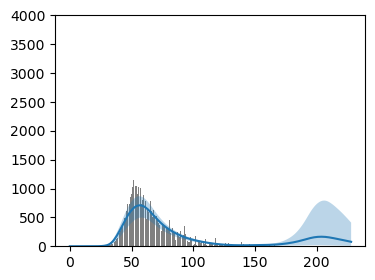

In [333]:
plt.figure(figsize=(4,3))
plt.bar(np.arange(T), Y, color='grey')
plt.plot(model.predict_EY(Ae, th_pa[0], th_pa[1:]))
plt.fill_between(np.arange(T+Tf),
                 conf_pa[:,0], conf_pa[:,1], alpha=0.3)
plt.ylim(0,4000)

Text(0, 0.5, 'deaths')

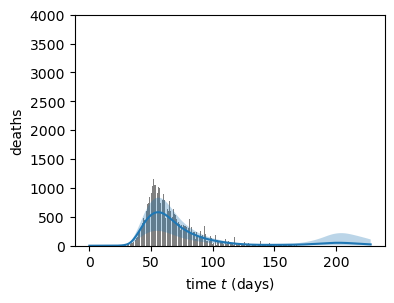

In [334]:
plt.figure(figsize=(4,3))
plt.bar(np.arange(T), Y, color='grey')
plt.plot(model.predict_EY(Ae, th_eb[0], th_eb[1:]))
plt.fill_between(np.arange(T+Tf),
                 conf_eb[:,0], conf_eb[:,1], alpha=0.3)
# plt.plot(conf_pa[:,0], color='C0', linewidth=1, linestyle='--')
# plt.plot(conf_pa[:,1], color='C0', linewidth=1, linestyle='--')
plt.ylim(0,4000)
plt.xlabel("time $t$ (days)"); plt.ylabel("deaths")

## increasing intervention

In [316]:
Tf = 60
Af = np.zeros([Tf, d])

In [317]:
A.shape

(169, 2)

In [318]:
Af[:,0] = np.full(Tf, 1)
Af[:,1] = Af_inc

In [319]:
Ae = np.concatenate([A, Af], 0)

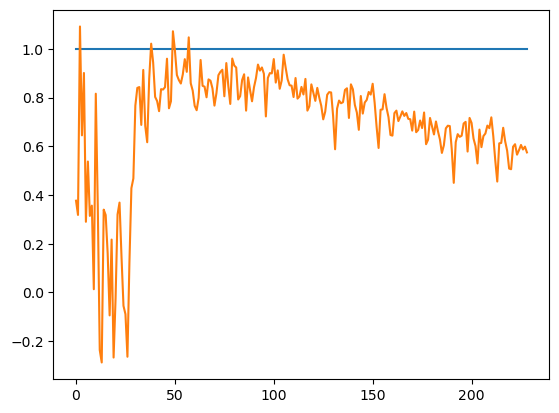

In [320]:
plt.plot(Ae)

(0.0, 4000.0)

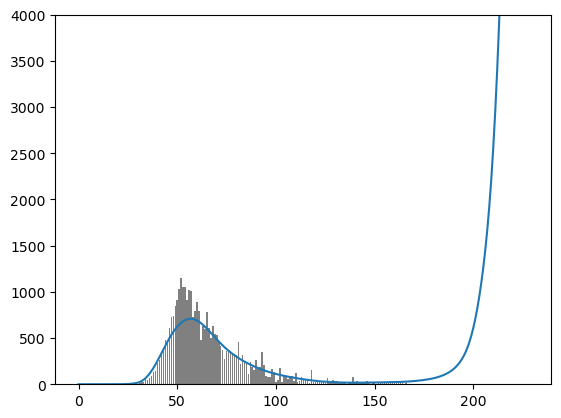

In [321]:
plt.bar(np.arange(T), Y, color='grey')
plt.plot(model.predict_EY(Ae, thats[i,0], thats[i,1:]))
# plt.fill_between(np.arange(T+Tf),
#                  conf_pa[:,0], conf_pa[:,1], alpha=0.3)
plt.ylim(0,4000)

## vanilla CR

In [229]:
conf_pa, _, _ = \
model.confidence_EY(Ae, thats[i,0], thats[i,1:],
                    covs[i], chi_pa, verbose=True)

optimization at t = 1 finished, lapse: 2.758sec.
optimization at t = 2 finished, lapse: 2.681sec.
optimization at t = 3 finished, lapse: 2.738sec.
optimization at t = 4 finished, lapse: 2.748sec.
optimization at t = 5 finished, lapse: 2.740sec.
optimization at t = 6 finished, lapse: 2.731sec.
optimization at t = 7 finished, lapse: 2.759sec.
optimization at t = 8 finished, lapse: 2.733sec.
optimization at t = 9 finished, lapse: 2.760sec.
optimization at t = 10 finished, lapse: 2.783sec.
optimization at t = 11 finished, lapse: 2.776sec.
optimization at t = 12 finished, lapse: 2.714sec.
optimization at t = 13 finished, lapse: 2.740sec.
optimization at t = 14 finished, lapse: 2.667sec.
optimization at t = 15 finished, lapse: 2.695sec.
optimization at t = 16 finished, lapse: 2.698sec.
optimization at t = 17 finished, lapse: 2.703sec.
optimization at t = 18 finished, lapse: 2.549sec.
optimization at t = 19 finished, lapse: 1.661sec.
optimization at t = 20 finished, lapse: 1.676sec.
optimizat

optimization at t = 164 finished, lapse: 6.410sec.
optimization at t = 165 finished, lapse: 2.626sec.
optimization at t = 166 finished, lapse: 1.927sec.
optimization at t = 167 finished, lapse: 1.692sec.
optimization at t = 168 finished, lapse: 3.909sec.
optimization at t = 169 finished, lapse: 2.105sec.
optimization at t = 170 finished, lapse: 1.869sec.
optimization at t = 171 finished, lapse: 2.606sec.
optimization at t = 172 finished, lapse: 1.320sec.
optimization at t = 173 finished, lapse: 1.230sec.
optimization at t = 174 finished, lapse: 1.853sec.
optimization at t = 175 finished, lapse: 1.724sec.
optimization at t = 176 finished, lapse: 2.251sec.
optimization at t = 177 finished, lapse: 1.466sec.
optimization at t = 178 finished, lapse: 2.304sec.
optimization at t = 179 finished, lapse: 1.715sec.
optimization at t = 180 finished, lapse: 3.059sec.
optimization at t = 181 finished, lapse: 2.532sec.
optimization at t = 182 finished, lapse: 2.555sec.
optimization at t = 183 finishe

## EBCR

In [230]:
conf_eb, _, _ = \
model.confidence_EY(Ae, ths_eb[i,0], ths_eb[i,1:],
                    covs_eb[i], chi_eb[i], verbose=True)

optimization at t = 1 finished, lapse: 2.769sec.
optimization at t = 2 finished, lapse: 2.757sec.
optimization at t = 3 finished, lapse: 2.762sec.
optimization at t = 4 finished, lapse: 2.770sec.
optimization at t = 5 finished, lapse: 2.767sec.
optimization at t = 6 finished, lapse: 2.785sec.
optimization at t = 7 finished, lapse: 2.760sec.
optimization at t = 8 finished, lapse: 2.710sec.
optimization at t = 9 finished, lapse: 2.782sec.
optimization at t = 10 finished, lapse: 2.730sec.
optimization at t = 11 finished, lapse: 2.720sec.
optimization at t = 12 finished, lapse: 2.670sec.
optimization at t = 13 finished, lapse: 2.682sec.
optimization at t = 14 finished, lapse: 2.672sec.
optimization at t = 15 finished, lapse: 2.679sec.
optimization at t = 16 finished, lapse: 2.431sec.
optimization at t = 17 finished, lapse: 1.814sec.
optimization at t = 18 finished, lapse: 2.133sec.
optimization at t = 19 finished, lapse: 1.779sec.
optimization at t = 20 finished, lapse: 1.684sec.
optimizat

optimization at t = 164 finished, lapse: 1.776sec.
optimization at t = 165 finished, lapse: 2.084sec.
optimization at t = 166 finished, lapse: 1.083sec.
optimization at t = 167 finished, lapse: 1.445sec.
optimization at t = 168 finished, lapse: 1.002sec.
optimization at t = 169 finished, lapse: 1.121sec.
optimization at t = 170 finished, lapse: 1.406sec.
optimization at t = 171 finished, lapse: 2.821sec.
optimization at t = 172 finished, lapse: 2.253sec.
optimization at t = 173 finished, lapse: 2.200sec.
optimization at t = 174 finished, lapse: 1.064sec.
optimization at t = 175 finished, lapse: 2.153sec.
optimization at t = 176 finished, lapse: 3.705sec.
optimization at t = 177 finished, lapse: 1.853sec.
optimization at t = 178 finished, lapse: 1.905sec.
optimization at t = 179 finished, lapse: 2.719sec.
optimization at t = 180 finished, lapse: 1.839sec.
optimization at t = 181 finished, lapse: 2.231sec.
optimization at t = 182 finished, lapse: 1.492sec.
optimization at t = 183 finishe

In [323]:
np.savez("counterfactual_freqepid_delphi_%s_inc.npz"%r,
         Ae = Ae, th_pa = thats[i], conf_pa = conf_pa,
         th_eb = ths_eb[i], conf_eb = conf_eb)

## plot

In [324]:
locals().update(np.load(
    "counterfactual_freqepid_delphi_%s_inc.npz"%r))

(0.0, 4000.0)

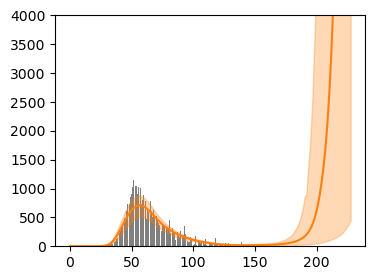

In [325]:
plt.figure(figsize=(4,3))
plt.bar(np.arange(T), Y, color='grey')
plt.plot(model.predict_EY(Ae, th_pa[0], th_pa[1:]), color='C1')
plt.fill_between(np.arange(T+Tf),
                 conf_pa[:,0], conf_pa[:,1], alpha=0.3, color='C1')
plt.ylim(0,4000)

Text(0, 0.5, 'deaths')

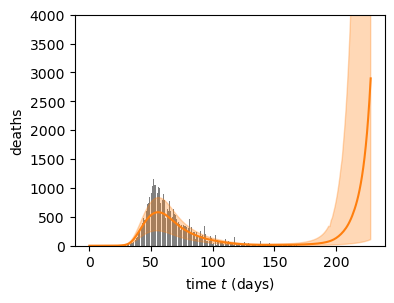

In [327]:
plt.figure(figsize=(4,3))
plt.bar(np.arange(T), Y, color='grey')
plt.plot(model.predict_EY(Ae, th_eb[0], th_eb[1:]), color='C1')
plt.fill_between(np.arange(T+Tf),
                 conf_eb[:,0], conf_eb[:,1], alpha=0.3, color='C1')
# plt.plot(conf_pa[:,0], color='C0', linewidth=1, linestyle='--')
# plt.plot(conf_pa[:,1], color='C0', linewidth=1, linestyle='--')
plt.ylim(0,4000)
plt.xlabel("time $t$ (days)"); plt.ylabel("deaths")

## epidemia result

In [95]:
EY_epi = np.array(pd.read_feather('counterfactual_epidemia_ny_dec.feather'))

Text(0, 0.5, 'deaths')

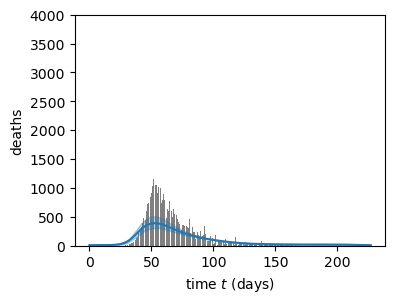

In [113]:
plt.figure(figsize=(4,3))
plt.bar(np.arange(T), Y, color='grey')
plt.plot(np.median(EY_epi,1), color='C0')
plt.fill_between(
    np.arange(T+Tf-1),
    np.quantile(EY_epi,0.975,1), 
    np.quantile(EY_epi,0.025,1), 
    alpha=0.3, color='C0'
)
plt.ylim(0,4000)
plt.xlabel("time $t$ (days)"); plt.ylabel("deaths")

In [114]:
EY_epi = np.array(pd.read_feather('counterfactual_epidemia_ny_inc.feather'))

Text(0, 0.5, 'deaths')

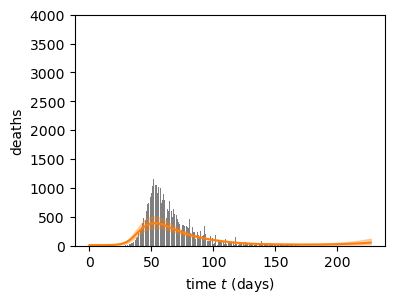

In [115]:
plt.figure(figsize=(4,3))
plt.bar(np.arange(T), Y, color='grey')
plt.plot(np.median(EY_epi,1), color='C1')
plt.fill_between(
    np.arange(T+Tf-1),
    np.quantile(EY_epi,0.975,1), 
    np.quantile(EY_epi,0.025,1), 
    alpha=0.3, color='C1'
)
plt.ylim(0,4000)
plt.xlabel("time $t$ (days)"); plt.ylabel("deaths")

In [116]:
EY_epi = np.array(pd.read_feather('counterfactual_epidemia_normal_ny_dec.feather'))

Text(0, 0.5, 'deaths')

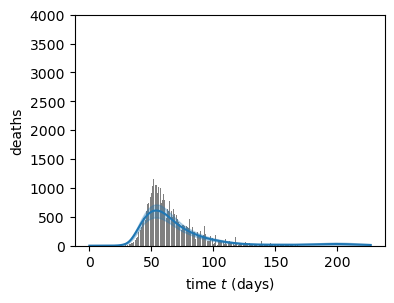

In [117]:
plt.figure(figsize=(4,3))
plt.bar(np.arange(T), Y, color='grey')
plt.plot(np.median(EY_epi,1), color='C0')
plt.fill_between(
    np.arange(T+Tf-1),
    np.quantile(EY_epi,0.975,1), 
    np.quantile(EY_epi,0.025,1), 
    alpha=0.3, color='C0'
)
plt.ylim(0,4000)
plt.xlabel("time $t$ (days)"); plt.ylabel("deaths")

In [118]:
EY_epi = np.array(pd.read_feather('counterfactual_epidemia_normal_ny_inc.feather'))

Text(0, 0.5, 'deaths')

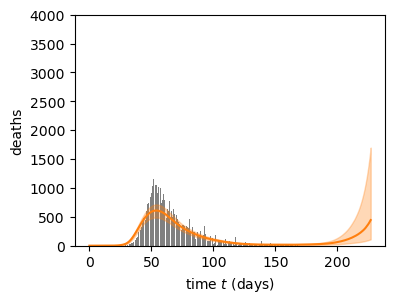

In [119]:
plt.figure(figsize=(4,3))
plt.bar(np.arange(T), Y, color='grey')
plt.plot(np.median(EY_epi,1), color='C1')
plt.fill_between(
    np.arange(T+Tf-1),
    np.quantile(EY_epi,0.975,1), 
    np.quantile(EY_epi,0.025,1), 
    alpha=0.3, color='C1'
)
plt.ylim(0,4000)
plt.xlabel("time $t$ (days)"); plt.ylabel("deaths")